#Import Libraries and Stuff

In [1]:
# Uncomment the following line to install torchbearer
!pip install torchbearer
import numpy as np
import torch
import torchbearer
from torch import optim
from torchbearer import Trial

ModuleNotFoundError: ignored

In [ ]:
# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
#Code for ASGD Optimizer has been ported from https://github.com/rahulkidambi/AccSGD/blob/master/AccSGD.py

from torch.optim.optimizer import Optimizer, required
import copy

class AccSGD(Optimizer):
    r"""Implements the algorithm proposed in https://arxiv.org/pdf/1704.08227.pdf, which is a provably accelerated method 
    for stochastic optimization. This has been employed in https://openreview.net/forum?id=rJTutzbA- for training several 
    deep learning models of practical interest. This code has been implemented by building on the construction of the SGD 
    optimization module found in pytorch codebase.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate (required)
        kappa (float, optional): ratio of long to short step (default: 1000)
        xi (float, optional): statistical advantage parameter (default: 10)
        smallConst (float, optional): any value <=1 (default: 0.7)
    Example:
        >>> from AccSGD import *
        >>> optimizer = AccSGD(model.parameters(), lr=0.1, kappa = 1000.0, xi = 10.0)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    """

    def __init__(self, params, lr=0.001, kappa = 1000.0, xi = 10.0, smallConst = 0.7, weight_decay=0):
        defaults = dict(lr=lr, kappa=kappa, xi=xi, smallConst=smallConst,
                        weight_decay=weight_decay)
        super(AccSGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AccSGD, self).__setstate__(state)

    def step(self, closure=None):
        """ Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            large_lr = (group['lr']*group['kappa'])/(group['smallConst'])
            Alpha = 1.0 - ((group['smallConst']*group['smallConst']*group['xi'])/group['kappa'])
            Beta = 1.0 - Alpha
            zeta = group['smallConst']/(group['smallConst']+Beta)
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                param_state = self.state[p]
                if 'momentum_buffer' not in param_state:
                    param_state['momentum_buffer'] = copy.deepcopy(p.data)
                buf = param_state['momentum_buffer']
                buf.mul_((1.0/Beta)-1.0)
                buf.add_(-large_lr,d_p)
                buf.add_(p.data)
                buf.mul_(Beta)

                p.data.add_(-group['lr'],d_p)
                p.data.mul_(zeta)
                p.data.add_(1.0-zeta,buf)

        return loss

#Prepare Data and Model Architecture for Training


#Download CIFAR10 Dataset

In [2]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

num_classes = 10

mean = [x / 255 for x in [125.3, 123.0, 113.9]]
std = [x / 255 for x in [63.0, 62.1, 66.7]]

#Perform Data augmentation to make robust models without requiring larger dataset, using Randomly Flipping the Image Horizontally and Randomly Cropping the Image
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomCrop(32, padding=4), transforms.ToTensor(),transforms.Normalize(mean, std)])
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

#Download and Transform the datasets
train_data = datasets.CIFAR10(root=".", train=True, download=True, transform=train_transform)
test_data = datasets.CIFAR10(root=".", train=False, download=True, transform=test_transform)
valid_data = datasets.CIFAR10(root=".", train=True, download=True, transform=train_transform,)

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified
Files already downloaded and verified


##Split Data into Train and Validation Sets

In [3]:
from torch.utils.data.sampler import SubsetRandomSampler

#Split Train Data into Train and Validation Data
#Desired ratio of split into Validation and Train Set
ratio = 0.2
num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(ratio * num_train))

np.random.seed(7)
np.random.shuffle(indices)
batch_size = 128

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

#Create Mini Batches for Train, Validation and Test Datasets
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, sampler=valid_sampler,pin_memory=True,)

In [4]:
print("Count of Train MiniBatches: ", len(train_loader))
print("Count of Validation MiniBatches: ", len(valid_loader))
print("Ratio of Count of Validation to Train Minibatches: ",len(valid_loader)/(len(valid_loader) + len(train_loader)))

Count of Train MiniBatches:  313
Count of Validation MiniBatches:  79
Ratio of Count of Validation to Train Minibatches:  0.20153061224489796


##Create Resnet44 Architecture

In [5]:
#Resnet Architecture ported from https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py and along the lines of https://arxiv.org/abs/1512.03385

import torch.nn as nn

class DownsampleCIFAR(nn.Module):  

  def __init__(self, nIn, nOut, stride):
    super(DownsampleCIFAR, self).__init__() 
    assert stride == 2    
    self.avg = nn.AvgPool2d(kernel_size=1, stride=stride)   

  def forward(self, x):   
    x = self.avg(x)  
    return torch.cat((x, x.mul(0)), 1)  

class ResnetBlock(nn.Module):

  expansion = 1
  def __init__(self, inplanes, planes, stride, downsample, Type):
    super(ResnetBlock, self).__init__()

    self.Type = Type

    self.norm1 = nn.BatchNorm2d(inplanes)
    self.conv_a = nn.Conv2d(inplanes, planes, 3, stride, padding = 1, bias = False)

    self.norm2 = nn.BatchNorm2d(planes)
    self.conv_b = nn.Conv2d(planes, planes, 3, stride = 1, padding = 1, bias = False)

    self.relu = nn.ReLU(inplace = True)
    self.downsample = downsample

  
  def forward(self, x):
    initial = x

    block = self.norm1(x)
    block = self.relu(x)

    if self.Type == 'both_preact':
      initial = block

    block = self.conv_a(block)
    block = self.norm2(block)
    block = self.relu(block)
    block = self.conv_b(block)

    if self.downsample is not None:
     initial = self.downsample(initial)

    return initial + block


class Resnet(nn.Module):

  def __init__(self, block, depth, num_classes):

    super(Resnet, self).__init__()

    self.num_classes = num_classes

    layer_blocks = (depth-2)//6

    self.conv = nn.Conv2d(3, 16, 3, 1, padding=1, bias = False)

    self.inplanes = 16
    self.conv1 = self.make_layer(block, 16, layer_blocks, 1)
    self.conv2 = self.make_layer(block, 32, layer_blocks, 2)
    self.conv3 = self.make_layer(block, 64, layer_blocks, 2)
    self.final_activation = nn.Sequential(nn.BatchNorm2d(64*block.expansion), nn.ReLU(inplace=True))
    self.avgpool = nn.AvgPool2d(8)
    self.classifier = nn.Linear(64*block.expansion, num_classes)
  
  def make_layer(self, block, planes, blocks, stride = 1):
    downsample = None

    if (stride != 1 or self.inplanes != planes*block.expansion):
      downsample = DownsampleCIFAR(self.inplanes, planes*block.expansion, stride)

    layers = []
    layers.append(block(self.inplanes, planes, stride, downsample, 'both_preact'))
    self.inplanes = planes*block.expansion
    for i in range(1, blocks):
      layers.append(block(self.inplanes, planes, 1, None, 'normal'))

    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv(x)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.final_activation(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    return self.classifier(x)


#Decayed Hyperparameter Schedule

##SGD

In [ ]:
def decayed_stats_SGD(lr, decay, epochs, change):

  #Load PreResnet44
  model = Resnet(ResnetBlock, 44, num_classes)
  model.eval()

  #Initialise all the metrics to be saved
  train_loss_SGD = np.zeros(epochs)
  train_accuracy_SGD = np.zeros(epochs)
  valid_loss_SGD = np.zeros(epochs)
  valid_accuracy_SGD = np.zeros(epochs)
  test_accuracy_SGD = np.zeros(epochs)
  test_loss_SGD = np.zeros(epochs)

  loss_function = nn.CrossEntropyLoss()
  device = "cuda:0" 

  i = 0

  #Initilise validation set error as criteria at change point
  error = 100
  prev_error = 100

  for epoch in range(epochs):

    #Creates a deep copy of the parameter and gradient tensors and makes them shareable to enable re-use of Resnet modules multiple times
    model = copy.deepcopy(model)
    optimiser = optim.SGD(model.parameters(), lr = lr, weight_decay=0.0005)

    #Train the model on training data
    trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy'], verbose=0).to(device)
    trial.with_generators(train_loader, valid_loader, test_generator=test_loader)

    result = trial.run(epochs=1)

    #At change points, update the hyperparameters depending on whether validation error reduced by more than 0.2% or not
    if epoch%change == 0:
      if ((prev_error-error)/prev_error < 0.002) and epoch!=0:
        
        if lr/decay < 0.001:
         lr = 0.001
        else:
            lr=lr/decay

      else:
          lr=lr

      prev_error = error


    #Compute the metrics on Test Dataset
    test_metric = trial.evaluate(data_key=torchbearer.TEST_DATA)

    #Store the metrics at each epoch
    train_loss_SGD[epoch] = result[0]['loss']
    train_accuracy_SGD[epoch] = result[0]['acc']
    valid_loss_SGD[epoch] = result[0]['val_loss']
    valid_accuracy_SGD[epoch] = result[0]['val_acc']
    test_accuracy_SGD[epoch] = result[0]['test_acc']
    test_loss_SGD[epoch] = result[0]['test_loss']

    error = 1 - result[0]['val_acc']

    print(epoch, lr, result)

  return lr, train_loss_SGD, train_accuracy_SGD, valid_loss_SGD, valid_accuracy_SGD, test_loss_SGD, test_accuracy_SGD

In [ ]:
final_lr_SGD, train_loss_SGD, train_accuracy_SGD, valid_loss_SGD, valid_accuracy_SGD, test_loss_SGD, test_accuracy_SGD = decayed_stats_SGD(0.27, 2, 120, 4)

0 0.27 [{'running_loss': 1.4959304332733154, 'running_acc': 0.4521874785423279, 'loss': 1.7118340730667114, 'acc': 0.3577750027179718, 'val_loss': 1.7312296628952026, 'val_acc': 0.353300005197525, 'train_steps': 313, 'validation_steps': 79, 'test_loss': 1.6418858766555786, 'test_acc': 0.384799987077713}]
1 0.27 [{'running_loss': 1.154645323753357, 'running_acc': 0.5834375023841858, 'loss': 1.2852612733840942, 'acc': 0.5321999788284302, 'val_loss': 2.3042330741882324, 'val_acc': 0.3391999900341034, 'train_steps': 313, 'validation_steps': 79, 'test_loss': 2.385242462158203, 'test_acc': 0.3564999997615814}]
2 0.27 [{'running_loss': 0.9531030654907227, 'running_acc': 0.6574999690055847, 'loss': 1.0266669988632202, 'acc': 0.6320750117301941, 'val_loss': 1.222274661064148, 'val_acc': 0.562999963760376, 'train_steps': 313, 'validation_steps': 79, 'test_loss': 1.2196778059005737, 'test_acc': 0.5755000114440918}]
3 0.27 [{'running_loss': 0.7783443927764893, 'running_acc': 0.727343738079071, 'lo

###Load Precomputed Metrics

In [6]:
# # Uncomment the below lines to restore the pre computed metrics for SGD on Batch Size 128 and Decayed Hyperparameter Schedule


# final_lr_SGD = 0.001
# train_loss_SGD = np.array([1.71183407, 1.28526127, 1.026667  , 0.85646063, 0.75804627,
#        0.67841744, 0.62236983, 0.57827258, 0.54884487, 0.52208292,
#        0.49632096, 0.47449213, 0.45768401, 0.43774241, 0.42715123,
#        0.41376776, 0.39789671, 0.38827759, 0.3779234 , 0.37062988,
#        0.36042044, 0.27575472, 0.25966477, 0.25247639, 0.25004151,
#        0.2443497 , 0.23836718, 0.2363598 , 0.23331961, 0.17285876,
#        0.16471817, 0.15806176, 0.15096639, 0.14549853, 0.14816734,
#        0.14103965, 0.1467904 , 0.11151568, 0.09702439, 0.09195668,
#        0.08726015, 0.0890381 , 0.08671602, 0.08106352, 0.07830024,
#        0.06416006, 0.06036014, 0.05559513, 0.05471288, 0.05302291,
#        0.0506792 , 0.05034265, 0.04890452, 0.04670165, 0.04607155,
#        0.04658717, 0.04401184, 0.03946382, 0.0355909 , 0.03395389,
#        0.03294867, 0.03182639, 0.03106846, 0.03110384, 0.03141483,
#        0.02983408, 0.03047764, 0.03141082, 0.02924451, 0.02773057,
#        0.02435952, 0.02646674, 0.02466619, 0.02501595, 0.02370333,
#        0.02333691, 0.02359404, 0.0233112 , 0.02237226, 0.02250148,
#        0.02328263, 0.02088352, 0.02169268, 0.02040396, 0.02376261,
#        0.02041387, 0.02031361, 0.01932379, 0.01970447, 0.02045042,
#        0.01945407, 0.01968991, 0.02080915, 0.01945067, 0.02095365,
#        0.02086464, 0.01965689, 0.01916631, 0.0201728 , 0.01881383,
#        0.01901531, 0.01883719, 0.01905164, 0.01928154, 0.0199898 ,
#        0.01861609, 0.01717682, 0.01712943, 0.01878098, 0.01925725,
#        0.01833346, 0.01940975, 0.01830148, 0.01828218, 0.01821741,
#        0.01812927, 0.01903502, 0.01783223, 0.01787212, 0.01850453])
# train_accuracy_SGD = np.array([0.357775  , 0.53219998, 0.63207501, 0.69979995, 0.73589998,
#        0.763475  , 0.78775001, 0.800125  , 0.81042498, 0.82104999,
#        0.82792497, 0.83494997, 0.84132499, 0.84907496, 0.85219997,
#        0.85705   , 0.86429995, 0.865825  , 0.86899996, 0.87277496,
#        0.87594998, 0.90652496, 0.90962499, 0.91249996, 0.91402495,
#        0.91544998, 0.91652501, 0.91964996, 0.92065001, 0.94042498,
#        0.94437498, 0.94544995, 0.94834995, 0.95094997, 0.94854999,
#        0.9508    , 0.94935   , 0.96127498, 0.9677    , 0.96934998,
#        0.97147501, 0.97047496, 0.97062498, 0.973625  , 0.97427499,
#        0.97899997, 0.98139995, 0.98232496, 0.98234999, 0.98314995,
#        0.98422498, 0.98412496, 0.98449999, 0.98534995, 0.98602498,
#        0.985425  , 0.98667496, 0.98789996, 0.98957497, 0.99054998,
#        0.99049997, 0.99094999, 0.99094999, 0.99102497, 0.99034995,
#        0.99177498, 0.99135   , 0.99102497, 0.99169999, 0.9921    ,
#        0.99329996, 0.99254996, 0.99307495, 0.99282497, 0.99327499,
#        0.99384999, 0.99362499, 0.99367499, 0.99362499, 0.99437499,
#        0.99355   , 0.99495   , 0.99432498, 0.99495   , 0.99317497,
#        0.99474996, 0.99467498, 0.99529999, 0.99482495, 0.99462497,
#        0.99524999, 0.99502498, 0.99474996, 0.99544996, 0.99467498,
#        0.99469995, 0.99539995, 0.99529999, 0.99439996, 0.99527496,
#        0.99567497, 0.995125  , 0.99567497, 0.99522495, 0.99487495,
#        0.99527496, 0.99634999, 0.99602497, 0.99567497, 0.99497497,
#        0.995175  , 0.99527496, 0.99527496, 0.99562496, 0.99567497,
#        0.99559999, 0.99535   , 0.99542499, 0.995525  , 0.99549997])
# valid_loss_SGD = np.array([1.73122966, 2.30423307, 1.22227466, 2.47773314, 1.5208379 ,
#        0.80600482, 0.84137398, 0.99803269, 1.27458441, 0.88261193,
#        1.06969869, 0.91364723, 0.96980542, 0.89699972, 0.83853579,
#        0.83376217, 0.71260041, 1.81022537, 1.47255492, 1.19162679,
#        0.89813977, 0.54259586, 0.53695595, 0.46139103, 0.50377321,
#        0.59190744, 0.82141846, 0.48486412, 0.4967874 , 0.40840662,
#        0.44597575, 0.38697013, 0.40809643, 0.43756872, 0.42477635,
#        0.51770598, 0.45272756, 0.3758288 , 0.35866839, 0.37360278,
#        0.36333883, 0.40663061, 0.44482943, 0.44368881, 0.39615053,
#        0.3677786 , 0.36932015, 0.37636629, 0.37281266, 0.38775149,
#        0.37449867, 0.37452367, 0.39547271, 0.41018614, 0.38931879,
#        0.37673032, 0.39178559, 0.37869397, 0.39053106, 0.38991183,
#        0.39134651, 0.38680965, 0.39379802, 0.39160994, 0.40651801,
#        0.39456013, 0.39439338, 0.39015308, 0.40463293, 0.38241422,
#        0.39269841, 0.38796908, 0.3977803 , 0.40445986, 0.40751547,
#        0.4063307 , 0.40358242, 0.40028176, 0.40996239, 0.38949591,
#        0.40242451, 0.40613821, 0.4077431 , 0.40497744, 0.41013288,
#        0.4182331 , 0.40609309, 0.3913447 , 0.39552724, 0.40412298,
#        0.39923185, 0.39897764, 0.41130805, 0.40710473, 0.41272798,
#        0.41098315, 0.40588596, 0.39993209, 0.42206013, 0.40449733,
#        0.40553182, 0.41300038, 0.40128013, 0.42643961, 0.40939635,
#        0.40487087, 0.40963998, 0.40821877, 0.41959572, 0.42644382,
#        0.41621882, 0.4048067 , 0.39695472, 0.40157816, 0.4165878 ,
#        0.41048202, 0.41482854, 0.40565974, 0.41004881, 0.40084565])
# valid_accuracy_SGD = np.array([0.35330001, 0.33919999, 0.56299996, 0.33750001, 0.55979997,
#        0.72999996, 0.70139998, 0.66979998, 0.63529998, 0.71079999,
#        0.66289997, 0.68019998, 0.68119997, 0.71359998, 0.72929996,
#        0.74149996, 0.76859999, 0.57669997, 0.61750001, 0.62819999,
#        0.7252    , 0.82749999, 0.82519996, 0.84819996, 0.83519995,
#        0.81149995, 0.75669998, 0.84179997, 0.8344    , 0.87079996,
#        0.86009997, 0.8775    , 0.87169999, 0.86449999, 0.86809999,
#        0.84309995, 0.8592    , 0.88529998, 0.89099997, 0.88609999,
#        0.89029998, 0.88099998, 0.87129998, 0.87099999, 0.8847    ,
#        0.8937    , 0.8951    , 0.89159995, 0.89399999, 0.89709997,
#        0.89359999, 0.89449996, 0.89120001, 0.88729995, 0.8915    ,
#        0.89459997, 0.89459997, 0.8962    , 0.8955    , 0.8969    ,
#        0.89469999, 0.89959997, 0.89839995, 0.90139997, 0.89449996,
#        0.898     , 0.89919996, 0.89589995, 0.89709997, 0.89929998,
#        0.90109998, 0.90019995, 0.90139997, 0.89749998, 0.89699996,
#        0.89609998, 0.8994    , 0.89679998, 0.89829999, 0.89849997,
#        0.8987    , 0.89419997, 0.89829999, 0.90079999, 0.90059996,
#        0.89969999, 0.89899999, 0.90069997, 0.9016    , 0.89739996,
#        0.89969999, 0.89849997, 0.8976    , 0.90029997, 0.90219998,
#        0.89919996, 0.89919996, 0.89999998, 0.89459997, 0.89749998,
#        0.8998    , 0.90009999, 0.89999998, 0.89569998, 0.89809996,
#        0.90019995, 0.89910001, 0.8962    , 0.89819998, 0.89649999,
#        0.89749998, 0.903     , 0.89809996, 0.90059996, 0.89659995,
#        0.8962    , 0.89829999, 0.89819998, 0.90279996, 0.89929998])
# test_loss_SGD = np.array([1.64188588, 2.38524246, 1.21967781, 2.73059344, 1.55100298,
#        0.81410384, 0.8585695 , 1.05481005, 1.32812321, 0.87950957,
#        1.1848495 , 0.93552524, 1.1010803 , 0.98213547, 0.83097184,
#        0.95674568, 0.7373367 , 2.11745644, 1.59605455, 1.29665112,
#        0.94242525, 0.53944367, 0.56099665, 0.44975933, 0.49403879,
#        0.63643163, 0.94555831, 0.48596478, 0.49059233, 0.40547591,
#        0.46340156, 0.38806054, 0.41738346, 0.45480436, 0.44443271,
#        0.52091473, 0.4828575 , 0.36450744, 0.34751353, 0.39073077,
#        0.37310904, 0.43214041, 0.45991483, 0.46153656, 0.40122142,
#        0.3614161 , 0.36506703, 0.37520042, 0.37759644, 0.3741492 ,
#        0.38264707, 0.38270789, 0.39315644, 0.41219586, 0.40006939,
#        0.38367864, 0.40689436, 0.38289958, 0.38433042, 0.38938457,
#        0.39129019, 0.39563847, 0.38606426, 0.39490119, 0.39954743,
#        0.39493337, 0.39529088, 0.39838091, 0.40936947, 0.3892439 ,
#        0.39534977, 0.39567327, 0.39033332, 0.39459291, 0.39949736,
#        0.39513731, 0.39700606, 0.3966141 , 0.39962494, 0.3935979 ,
#        0.39304924, 0.39797151, 0.39733136, 0.39686424, 0.39907348,
#        0.39787087, 0.40117523, 0.39703894, 0.39788932, 0.40220422,
#        0.40013745, 0.40032554, 0.39577672, 0.40277657, 0.39950442,
#        0.39942083, 0.39826936, 0.3992089 , 0.39844131, 0.39743015,
#        0.40036839, 0.40202573, 0.401943  , 0.40258807, 0.40447396,
#        0.402731  , 0.40506336, 0.40851405, 0.40168253, 0.40306771,
#        0.40251699, 0.39553562, 0.40329346, 0.40636069, 0.40456292,
#        0.40338662, 0.4035438 , 0.4028357 , 0.40391821, 0.40295967])
# test_accuracy_SGD = np.array([0.38479999, 0.3565    , 0.57550001, 0.3423    , 0.579     ,
#        0.73449999, 0.71169996, 0.66229999, 0.63769996, 0.72439998,
#        0.65029997, 0.68419999, 0.67019999, 0.70059997, 0.74329996,
#        0.72709996, 0.77059996, 0.55979997, 0.62650001, 0.61699998,
#        0.72569996, 0.83039999, 0.82539999, 0.8531    , 0.84509999,
#        0.80559999, 0.74180001, 0.84649998, 0.84189999, 0.87459999,
#        0.86179996, 0.88119996, 0.87619996, 0.86129999, 0.86949998,
#        0.84869999, 0.85780001, 0.89109999, 0.89539999, 0.88889998,
#        0.89309996, 0.87579995, 0.87769997, 0.87360001, 0.88949996,
#        0.89849997, 0.89749998, 0.89639997, 0.89969999, 0.8987    ,
#        0.89819998, 0.89779997, 0.89589995, 0.89379996, 0.8944    ,
#        0.8987    , 0.8933    , 0.89889997, 0.90059996, 0.89989996,
#        0.90069997, 0.89989996, 0.90169996, 0.90239996, 0.9016    ,
#        0.90029997, 0.90189999, 0.89910001, 0.89919996, 0.9034    ,
#        0.90239996, 0.90239996, 0.90329999, 0.9034    , 0.90309995,
#        0.90179998, 0.9023    , 0.90319997, 0.90369999, 0.90379995,
#        0.90489995, 0.90329999, 0.9023    , 0.90249997, 0.90199995,
#        0.90129995, 0.90129995, 0.90270001, 0.9012    , 0.90239996,
#        0.90219998, 0.90259999, 0.90239996, 0.90149999, 0.90309995,
#        0.90079999, 0.90279996, 0.90309995, 0.90169996, 0.90109998,
#        0.90169996, 0.90199995, 0.90209997, 0.90169996, 0.90090001,
#        0.90199995, 0.90169996, 0.90149999, 0.90189999, 0.90219998,
#        0.90309995, 0.90259999, 0.90259999, 0.90199995, 0.90219998,
#        0.9023    , 0.90270001, 0.90279996, 0.90199995, 0.90309995])

In [ ]:
print("Final Learning Rate reached at the end of training: ", final_lr_SGD)
print("Training Loss Set: ", repr(train_loss_SGD))
print("Training Accuracy Set: ", repr(train_accuracy_SGD))
print("Validation Loss Set: ", repr(valid_loss_SGD))
print("Validation Accuracy Set: ",repr(valid_accuracy_SGD))
print("Test Loss Set: ", repr(test_loss_SGD))
print("Test Accuracy Set: ",repr(test_accuracy_SGD))

Final Learning Rate reached at the end of training:  0.001
Training Loss Set:  array([1.71183407, 1.28526127, 1.026667  , 0.85646063, 0.75804627,
       0.67841744, 0.62236983, 0.57827258, 0.54884487, 0.52208292,
       0.49632096, 0.47449213, 0.45768401, 0.43774241, 0.42715123,
       0.41376776, 0.39789671, 0.38827759, 0.3779234 , 0.37062988,
       0.36042044, 0.27575472, 0.25966477, 0.25247639, 0.25004151,
       0.2443497 , 0.23836718, 0.2363598 , 0.23331961, 0.17285876,
       0.16471817, 0.15806176, 0.15096639, 0.14549853, 0.14816734,
       0.14103965, 0.1467904 , 0.11151568, 0.09702439, 0.09195668,
       0.08726015, 0.0890381 , 0.08671602, 0.08106352, 0.07830024,
       0.06416006, 0.06036014, 0.05559513, 0.05471288, 0.05302291,
       0.0506792 , 0.05034265, 0.04890452, 0.04670165, 0.04607155,
       0.04658717, 0.04401184, 0.03946382, 0.0355909 , 0.03395389,
       0.03294867, 0.03182639, 0.03106846, 0.03110384, 0.03141483,
       0.02983408, 0.03047764, 0.03141082, 0.02924

##Heavy Ball

In [ ]:
def decayed_stats_HeavyBall(lr, momentum, decay, epochs, change):

  #Load PreResnet44
  model = Resnet(ResnetBlock, 44, num_classes)
  model.eval()

  #Initialise all the metrics to be saved
  train_loss_HeavyBall = np.zeros(epochs)
  train_accuracy_HeavyBall = np.zeros(epochs)
  valid_loss_HeavyBall = np.zeros(epochs)
  valid_accuracy_HeavyBall = np.zeros(epochs)
  test_accuracy_HeavyBall = np.zeros(epochs)
  test_loss_HeavyBall = np.zeros(epochs)

  loss_function = nn.CrossEntropyLoss()
  device = "cuda:0" 

  #Initilise validation set error as criteria at change point
  error = 100
  prev_error = 100

  for epoch in range(epochs):

    #Creates a deep copy of the parameter and gradient tensors and makes them shareable to enable re-use of Resnet modules multiple times
    model = copy.deepcopy(model)
    optimiser = optim.SGD(model.parameters(), lr = lr, momentum = momentum, weight_decay=0.0005)

    #Train the model on training data
    trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy'],  verbose=0).to(device)
    trial.with_generators(train_loader, valid_loader, test_generator=test_loader)

    result = trial.run(epochs=1)

    #At change points, update the hyperparameters depending on whether validation error reduced by more than 0.2% or not
    if epoch%change == 0:
      if ((prev_error-error)/prev_error < 0.002) and epoch!=0:
        
        if lr/decay < 0.001:
         lr = 0.001
        else:
            lr=lr/decay

      else:
          lr=lr

      prev_error = error

    #Compute the metrics on Test Dataset
    trial.evaluate(data_key=torchbearer.TEST_DATA)

    #Store the metrics at each epoch
    train_loss_HeavyBall[epoch] = result[0]['loss']
    train_accuracy_HeavyBall[epoch] = result[0]['acc']
    valid_loss_HeavyBall[epoch] = result[0]['val_loss']
    valid_accuracy_HeavyBall[epoch] = result[0]['val_acc']
    test_accuracy_HeavyBall[epoch] = result[0]['test_acc']
    test_loss_HeavyBall[epoch] = result[0]['test_loss']

    error = 1 - result[0]['val_acc']

    print(epoch, lr, momentum, result)

  return lr, train_loss_HeavyBall, train_accuracy_HeavyBall, valid_loss_HeavyBall, valid_accuracy_HeavyBall, test_loss_HeavyBall, test_accuracy_HeavyBall

In [ ]:
final_lr_HeavyBall, train_loss_HeavyBall, train_accuracy_HeavyBall, valid_loss_HeavyBall, valid_accuracy_HeavyBall, test_loss_HeavyBall, test_accuracy_HeavyBall = decayed_stats_HeavyBall(0.27, 0.5, 2, 120, 4)

0 0.27 0.5 [{'running_loss': 1.4122717380523682, 'running_acc': 0.47968748211860657, 'loss': 1.6455152034759521, 'acc': 0.3839249908924103, 'val_loss': 1.7173004150390625, 'val_acc': 0.407399982213974, 'train_steps': 313, 'validation_steps': 79, 'test_loss': 1.7037882804870605, 'test_acc': 0.42089998722076416}]
1 0.27 0.5 [{'running_loss': 1.0947754383087158, 'running_acc': 0.6037499904632568, 'loss': 1.2118505239486694, 'acc': 0.5630999803543091, 'val_loss': 1.3329198360443115, 'val_acc': 0.5327000021934509, 'train_steps': 313, 'validation_steps': 79, 'test_loss': 1.305202603340149, 'test_acc': 0.5383999943733215}]
2 0.27 0.5 [{'running_loss': 0.8957086205482483, 'running_acc': 0.6773437261581421, 'loss': 0.9726648926734924, 'acc': 0.6537249684333801, 'val_loss': 1.4468469619750977, 'val_acc': 0.5309000015258789, 'train_steps': 313, 'validation_steps': 79, 'test_loss': 1.4749679565429688, 'test_acc': 0.5345999598503113}]
3 0.27 0.5 [{'running_loss': 0.7700963616371155, 'running_acc': 

###Load Precomputed Metrics

In [7]:
# # Uncomment the below lines to restore the pre computed metrics for Heavy Ball on Batch Size 128 and Decayed Hyperparameter Schedule

# final_lr_HeavyBall = 0.001
# train_loss_HeavyBall = np.array([1.63639855, 1.16524589, 0.93842459, 0.80115128, 0.71703941,
#        0.65074068, 0.60588378, 0.56748879, 0.54011595, 0.52048105,
#        0.49842277, 0.4781481 , 0.47079977, 0.45433897, 0.44086391,
#        0.43515238, 0.42260206, 0.42274201, 0.40584901, 0.40511623,
#        0.39582601, 0.39122081, 0.38812533, 0.37928233, 0.37536055,
#        0.28057501, 0.25989857, 0.25889018, 0.2537483 , 0.2507388 ,
#        0.24967523, 0.25530261, 0.2522625 , 0.17712839, 0.16458513,
#        0.16427112, 0.15593426, 0.15731791, 0.15589088, 0.15641476,
#        0.15255828, 0.10770587, 0.09357908, 0.08927524, 0.08619794,
#        0.08248061, 0.08202739, 0.08139143, 0.0802817 , 0.07820573,
#        0.08004044, 0.07801978, 0.0795709 , 0.07677002, 0.07564631,
#        0.07951888, 0.08007317, 0.05003384, 0.04218028, 0.03755803,
#        0.03431063, 0.03510899, 0.03455525, 0.03459555, 0.03180457,
#        0.02613511, 0.02152506, 0.02148007, 0.01898943, 0.01803452,
#        0.01691009, 0.01813209, 0.01760868, 0.01644369, 0.01767487,
#        0.01569961, 0.01736432, 0.01515401, 0.01209177, 0.0123928 ,
#        0.01241801, 0.01147574, 0.01128419, 0.012046  , 0.01230034,
#        0.01005275, 0.00977574, 0.00988733, 0.00985803, 0.01017826,
#        0.00998743, 0.00927842, 0.00939303, 0.00909515, 0.00918936,
#        0.00895024, 0.00855465, 0.00840965, 0.00914173, 0.00894787,
#        0.00892666, 0.00919945, 0.00835487, 0.00851858, 0.00866958,
#        0.00821259, 0.00766291, 0.00825235, 0.00884607, 0.00868431,
#        0.00896737, 0.00820503, 0.00912   , 0.00859701, 0.00849906,
#        0.00773092, 0.00800199, 0.00839519, 0.00760326, 0.00846684])
# train_accuracy_HeavyBall = np.array([0.39045   , 0.57997501, 0.66877496, 0.72149998, 0.74822497,
#        0.77329999, 0.79004997, 0.80394995, 0.81355   , 0.82009995,
#        0.82782495, 0.83524996, 0.83739996, 0.84265   , 0.84884995,
#        0.847525  , 0.85502499, 0.85420001, 0.86104995, 0.85914999,
#        0.86364996, 0.86495   , 0.86532497, 0.867975  , 0.87062496,
#        0.9052    , 0.91029996, 0.91104996, 0.91249996, 0.914325  ,
#        0.91525   , 0.91277498, 0.91177499, 0.93895   , 0.94312495,
#        0.944125  , 0.94647497, 0.94509995, 0.94637495, 0.94529998,
#        0.94734997, 0.963175  , 0.96899998, 0.96982497, 0.97147501,
#        0.97364998, 0.97192496, 0.97292495, 0.97359997, 0.97382498,
#        0.97382498, 0.97372496, 0.97277498, 0.97347498, 0.97507495,
#        0.97332495, 0.97189999, 0.98499995, 0.98772496, 0.98857498,
#        0.98984998, 0.98949999, 0.98995   , 0.98954999, 0.99072498,
#        0.99239999, 0.994425  , 0.99404997, 0.99537498, 0.99497497,
#        0.99582499, 0.99519998, 0.99567497, 0.99605   , 0.9957    ,
#        0.99632496, 0.99549997, 0.99637496, 0.99759996, 0.99729997,
#        0.99734998, 0.99754995, 0.99789995, 0.99724996, 0.99739999,
#        0.99809998, 0.99822497, 0.99812496, 0.99812496, 0.997675  ,
#        0.99794996, 0.99822497, 0.99812496, 0.99847496, 0.99817497,
#        0.99839997, 0.99842495, 0.99855   , 0.9982    , 0.99859995,
#        0.99832499, 0.99822497, 0.99862498, 0.99869996, 0.99842495,
#        0.99864995, 0.99884999, 0.99844998, 0.99814999, 0.99859995,
#        0.99839997, 0.99862498, 0.99827498, 0.99857497, 0.99839997,
#        0.9989    , 0.99874997, 0.99847496, 0.99892497, 0.99834996])
# valid_loss_HeavyBall = np.array([1.62342262, 1.23547566, 1.19479787, 1.53580368, 1.08412611,
#        0.90649474, 0.75236231, 0.8768388 , 1.15808451, 0.75439602,
#        0.90548778, 0.8853935 , 0.63843179, 0.63551033, 0.80657756,
#        0.86939639, 0.66458052, 0.71015853, 0.98159319, 0.67434543,
#        0.62285471, 0.69211686, 0.73795903, 0.77567118, 0.75192147,
#        0.46415925, 0.45307934, 0.48942471, 0.57367247, 0.5518117 ,
#        0.45561317, 0.64142799, 0.58449107, 0.36775607, 0.44709939,
#        0.37292141, 0.47742018, 0.48038238, 0.41485056, 0.45572093,
#        0.39309034, 0.34107766, 0.36909676, 0.36279622, 0.35023731,
#        0.39409408, 0.39514256, 0.38495493, 0.40753016, 0.37448061,
#        0.40596312, 0.3547467 , 0.43357411, 0.38619399, 0.38813961,
#        0.39045057, 0.41463694, 0.3487103 , 0.35101467, 0.33390051,
#        0.34542489, 0.36648101, 0.36530775, 0.35734597, 0.36367124,
#        0.35189992, 0.34472728, 0.34275562, 0.35179687, 0.35628679,
#        0.35194764, 0.33613381, 0.3522813 , 0.36797574, 0.36452708,
#        0.37453303, 0.36632472, 0.35407275, 0.35510811, 0.37291777,
#        0.35329685, 0.37258849, 0.3596327 , 0.37167972, 0.37243861,
#        0.38023359, 0.35199553, 0.35344142, 0.36755151, 0.35836834,
#        0.35599712, 0.35985643, 0.36201614, 0.35736108, 0.35841039,
#        0.36518463, 0.36943892, 0.36624932, 0.3628391 , 0.36281943,
#        0.36851233, 0.3740285 , 0.36143878, 0.38417286, 0.3762829 ,
#        0.35935313, 0.36690712, 0.35444233, 0.36925125, 0.37213659,
#        0.36541107, 0.37186453, 0.37104961, 0.35882875, 0.37652409,
#        0.36537334, 0.37899083, 0.36350381, 0.37925407, 0.3580831 ])
# valid_accuracy_HeavyBall = np.array([0.41429999, 0.54809999, 0.59920001, 0.53189999, 0.64749998,
#        0.69089997, 0.74189997, 0.70309997, 0.64699996, 0.73640001,
#        0.7087    , 0.70829999, 0.78179997, 0.78319997, 0.72490001,
#        0.71700001, 0.77469999, 0.76459998, 0.6857    , 0.77459997,
#        0.79719996, 0.76980001, 0.76279998, 0.76629996, 0.76339996,
#        0.84779996, 0.8477    , 0.84129995, 0.81949997, 0.81979996,
#        0.84779996, 0.79049999, 0.80769998, 0.88229996, 0.85829997,
#        0.87979996, 0.85249996, 0.85420001, 0.87109995, 0.85969996,
#        0.87219995, 0.89219999, 0.89019996, 0.88799995, 0.89559996,
#        0.8926    , 0.88189995, 0.88849998, 0.88249999, 0.88709998,
#        0.88369995, 0.89459997, 0.87709999, 0.88629997, 0.88699996,
#        0.88379997, 0.87909997, 0.90499997, 0.9034    , 0.90919995,
#        0.9048    , 0.90169996, 0.903     , 0.9059    , 0.90399998,
#        0.90419996, 0.90899998, 0.9095    , 0.90789998, 0.90969998,
#        0.90979999, 0.91229999, 0.90989995, 0.90709996, 0.91049999,
#        0.90889996, 0.9084    , 0.90819997, 0.90829998, 0.90959996,
#        0.91219997, 0.90869999, 0.90919995, 0.90919995, 0.91399997,
#        0.91239995, 0.91069996, 0.91349995, 0.91049999, 0.90999997,
#        0.91229999, 0.91339999, 0.91149998, 0.91339999, 0.91099995,
#        0.9113    , 0.91079998, 0.91279995, 0.91249996, 0.90999997,
#        0.9109    , 0.91179997, 0.91289997, 0.90779996, 0.90979999,
#        0.91099995, 0.91039997, 0.91339999, 0.91169995, 0.91209996,
#        0.91159999, 0.91109997, 0.90979999, 0.91169995, 0.9091    ,
#        0.91149998, 0.91079998, 0.91319996, 0.91060001, 0.91599995])
# test_loss_HeavyBall = np.array([1.60591662, 1.1914351 , 1.27395296, 1.61479247, 1.15463042,
#        0.9112978 , 0.7439096 , 0.91708374, 1.1029551 , 0.74615741,
#        0.95354801, 0.92271948, 0.61847419, 0.65734327, 0.83164448,
#        0.88968611, 0.67372102, 0.73523706, 0.97652495, 0.68480676,
#        0.5937553 , 0.69509816, 0.75287068, 0.8124947 , 0.78880024,
#        0.46034014, 0.46721992, 0.47797444, 0.604581  , 0.5462262 ,
#        0.41720402, 0.66754413, 0.55222332, 0.35296655, 0.45391065,
#        0.36314747, 0.48926198, 0.4686349 , 0.4405002 , 0.46224856,
#        0.39932123, 0.33536184, 0.37126353, 0.35161412, 0.35590288,
#        0.41079843, 0.39812738, 0.39554238, 0.41176298, 0.37277153,
#        0.41893753, 0.35542965, 0.4392381 , 0.37396297, 0.3828617 ,
#        0.40712425, 0.42115387, 0.33073315, 0.35888204, 0.34095594,
#        0.35057032, 0.36620033, 0.36187476, 0.3737314 , 0.35962859,
#        0.36073065, 0.35075137, 0.35714161, 0.35152066, 0.36065724,
#        0.35375023, 0.36053643, 0.35544458, 0.35669088, 0.3641853 ,
#        0.36475533, 0.37937796, 0.36674395, 0.36566937, 0.36105937,
#        0.36656183, 0.36568514, 0.36543134, 0.36367676, 0.37226641,
#        0.36605671, 0.36457106, 0.36656725, 0.36508381, 0.36835787,
#        0.36713141, 0.36508238, 0.36344811, 0.36629426, 0.36584523,
#        0.36961344, 0.36795497, 0.36867648, 0.36686686, 0.36811981,
#        0.36344513, 0.36942673, 0.36982876, 0.36895025, 0.37065941,
#        0.36663896, 0.37236652, 0.37170222, 0.3675074 , 0.36788741,
#        0.3720966 , 0.36677676, 0.36981419, 0.37307525, 0.37006655,
#        0.36813325, 0.37113562, 0.37028101, 0.37077329, 0.36784762])
# test_accuracy_HeavyBall = np.array([0.4276    , 0.56639999, 0.58829999, 0.53960001, 0.6505    ,
#        0.6961    , 0.74869996, 0.70039999, 0.67109996, 0.74430001,
#        0.70120001, 0.70910001, 0.78839999, 0.78119999, 0.73499995,
#        0.71939999, 0.77389997, 0.7683    , 0.70660001, 0.7816    ,
#        0.80239999, 0.77399999, 0.7622    , 0.76299995, 0.76099998,
#        0.84630001, 0.85079998, 0.8484    , 0.8161    , 0.82309997,
#        0.86299998, 0.79339999, 0.82409996, 0.88940001, 0.86059999,
#        0.8836    , 0.85459995, 0.85509998, 0.87469995, 0.86139995,
#        0.87619996, 0.89779997, 0.89219999, 0.89379996, 0.89679998,
#        0.88789999, 0.88789999, 0.88909996, 0.88519996, 0.89219999,
#        0.8829    , 0.89839995, 0.88189995, 0.89719999, 0.89279997,
#        0.88549995, 0.87979996, 0.90999997, 0.903     , 0.90849996,
#        0.91079998, 0.90789998, 0.9102    , 0.90469998, 0.91119999,
#        0.91109997, 0.91319996, 0.91159999, 0.9127    , 0.9127    ,
#        0.91339999, 0.91060001, 0.91399997, 0.91459996, 0.91249996,
#        0.91349995, 0.90959996, 0.91259998, 0.91429996, 0.9152    ,
#        0.91419995, 0.91419995, 0.91289997, 0.9152    , 0.91419995,
#        0.9149    , 0.91499996, 0.91599995, 0.9149    , 0.91499996,
#        0.91569996, 0.91659999, 0.91499996, 0.91569996, 0.9152    ,
#        0.9145    , 0.91419995, 0.91509998, 0.91439998, 0.91459996,
#        0.9152    , 0.91479999, 0.91479999, 0.91469997, 0.91479999,
#        0.91589999, 0.91419995, 0.91539997, 0.91469997, 0.91549999,
#        0.9149    , 0.91389996, 0.9149    , 0.91569996, 0.91529995,
#        0.91539997, 0.91579998, 0.91479999, 0.91609997, 0.91529995])

In [ ]:
print("Final Learning Rate reached at the end of training: ", final_lr_HeavyBall)
print("Training Loss Set: ",repr(train_loss_HeavyBall))
print("Training Accuracy Set: ",repr(train_accuracy_HeavyBall))
print("Validation Loss Set: ", repr(valid_loss_HeavyBall))
print("Validation Accuracy Set: ",repr(valid_accuracy_HeavyBall))
print("Test Loss Set: ", repr(test_loss_HeavyBall))
print("Test Accuracy Set: ",repr(test_accuracy_HeavyBall))

Final Learning Rate reached at the end of training:  0.001
Training Loss Set:  array([1.63639855, 1.16524589, 0.93842459, 0.80115128, 0.71703941,
       0.65074068, 0.60588378, 0.56748879, 0.54011595, 0.52048105,
       0.49842277, 0.4781481 , 0.47079977, 0.45433897, 0.44086391,
       0.43515238, 0.42260206, 0.42274201, 0.40584901, 0.40511623,
       0.39582601, 0.39122081, 0.38812533, 0.37928233, 0.37536055,
       0.28057501, 0.25989857, 0.25889018, 0.2537483 , 0.2507388 ,
       0.24967523, 0.25530261, 0.2522625 , 0.17712839, 0.16458513,
       0.16427112, 0.15593426, 0.15731791, 0.15589088, 0.15641476,
       0.15255828, 0.10770587, 0.09357908, 0.08927524, 0.08619794,
       0.08248061, 0.08202739, 0.08139143, 0.0802817 , 0.07820573,
       0.08004044, 0.07801978, 0.0795709 , 0.07677002, 0.07564631,
       0.07951888, 0.08007317, 0.05003384, 0.04218028, 0.03755803,
       0.03431063, 0.03510899, 0.03455525, 0.03459555, 0.03180457,
       0.02613511, 0.02152506, 0.02148007, 0.01898

##NAG

In [ ]:
def decayed_stats_NAG(lr, momentum, decay, epochs, change):

  #Load PreResnet44
  model = Resnet(ResnetBlock, 44, num_classes)
  model.eval()

  #Initialise all the metrics to be saved
  train_loss_NAG = np.zeros(epochs)
  train_accuracy_NAG = np.zeros(epochs)
  valid_loss_NAG = np.zeros(epochs)
  valid_accuracy_NAG = np.zeros(epochs)
  test_accuracy_NAG = np.zeros(epochs)
  test_loss_NAG = np.zeros(epochs)

  loss_function = nn.CrossEntropyLoss()
  device = "cuda:0" 

  #Initilise validation set error as criteria at change point
  error = 100
  prev_error = 100

  for epoch in range(epochs):

      #Creates a deep copy of the parameter and gradient tensors and makes them shareable to enable re-use of Resnet modules multiple times
      model = copy.deepcopy(model)
      optimiser = optim.SGD(model.parameters(), lr = lr, momentum = momentum, nesterov = True, weight_decay=0.0005)

      #Train the model on training data
      trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy'],  verbose=0).to(device)
      trial.with_generators(train_loader, valid_loader, test_generator=test_loader)

      result = trial.run(epochs=1)

      #At change points, update the hyperparameters depending on whether validation error reduced by more than 0.2% or not
      if epoch%change == 0:
        if ((prev_error-error)/prev_error < 0.002) and epoch!=0:
        
          if lr/decay < 0.001:
           lr = 0.001
          else:
              lr=lr/decay

        else:
            lr=lr

        prev_error = error

      #Compute the metrics on Test Dataset
      trial.evaluate(data_key=torchbearer.TEST_DATA)

      #Store the metrics at each epoch
      train_loss_NAG[epoch] = result[0]['loss']
      train_accuracy_NAG[epoch] = result[0]['acc']
      valid_loss_NAG[epoch] = result[0]['val_loss']
      valid_accuracy_NAG[epoch] = result[0]['val_acc']
      test_accuracy_NAG[epoch] = result[0]['test_acc']
      test_loss_NAG[epoch] = result[0]['test_loss']

      error = 1 - result[0]['val_acc']

      print(epoch, lr, momentum, result)

  return lr, train_loss_NAG, train_accuracy_NAG, valid_loss_NAG, valid_accuracy_NAG, test_loss_NAG, test_accuracy_NAG

In [ ]:
final_lr_NAG, train_loss_NAG, train_accuracy_NAG, valid_loss_NAG, valid_accuracy_NAG, test_loss_NAG, test_accuracy_NAG = decayed_stats_NAG(0.27, 0.5, 2, 120, 4) 

###Load Precomputed Metrics

In [9]:
# # Uncomment the below lines to restore the pre computed metrics for NAG on Batch Size 128 and Decayed Hyperparameter Schedule


# final_lr_NAG = 0.001
# train_loss_NAG = np.array([1.65498281, 1.19095516, 0.95103908, 0.7941938 , 0.7077682 ,
#        0.64279735, 0.59541982, 0.56061363, 0.53479171, 0.51115042,
#        0.49727473, 0.4761408 , 0.46657565, 0.45412764, 0.44297096,
#        0.43352497, 0.42456883, 0.41604123, 0.40915355, 0.39653465,
#        0.40108058, 0.39015427, 0.38441992, 0.37495151, 0.3743757 ,
#        0.26932809, 0.25699767, 0.25294313, 0.25303888, 0.25109008,
#        0.24842639, 0.25559685, 0.24500842, 0.17854191, 0.16089088,
#        0.15504552, 0.15424499, 0.15798311, 0.15427405, 0.15110721,
#        0.14913288, 0.10288537, 0.09263112, 0.08910806, 0.08320157,
#        0.08016934, 0.07846639, 0.07685111, 0.07601637, 0.07926019,
#        0.07767212, 0.07647746, 0.07217151, 0.05037781, 0.0445978 ,
#        0.03975864, 0.03660988, 0.03536596, 0.03785622, 0.03356153,
#        0.03723579, 0.02757312, 0.02255934, 0.02269465, 0.02097191,
#        0.01999737, 0.01962481, 0.01898594, 0.01954941, 0.01777128,
#        0.01776557, 0.01667634, 0.01786612, 0.01656728, 0.01734448,
#        0.01636587, 0.01664862, 0.01397069, 0.01255884, 0.01288573,
#        0.01240814, 0.01136595, 0.01115855, 0.01172929, 0.01123302,
#        0.01094872, 0.01054471, 0.01083193, 0.0106322 , 0.01033903,
#        0.00988976, 0.00981284, 0.01016284, 0.01002517, 0.00988318,
#        0.01003138, 0.0096426 , 0.01032017, 0.00911949, 0.00975328,
#        0.01024343, 0.01067175, 0.00918417, 0.01006736, 0.00984796,
#        0.00997536, 0.0094613 , 0.00913448, 0.00894703, 0.00994386,
#        0.00923446, 0.00911251, 0.00887064, 0.00929435, 0.00946052,
#        0.0090104 , 0.00939149, 0.00923066, 0.00933375, 0.00866602])
# train_accuracy_NAG = np.array([0.38322499, 0.57045001, 0.65959996, 0.72227496, 0.75339997,
#        0.77634996, 0.79427499, 0.80675   , 0.81612498, 0.82279998,
#        0.828125  , 0.83652496, 0.83939999, 0.84332496, 0.84794998,
#        0.85152495, 0.8527    , 0.85904998, 0.85907495, 0.8646    ,
#        0.86212498, 0.86519998, 0.86792499, 0.86947501, 0.87107497,
#        0.90939999, 0.91235   , 0.91289997, 0.91297495, 0.91359997,
#        0.91404998, 0.91275001, 0.913275  , 0.9386    , 0.94322497,
#        0.94714999, 0.94645   , 0.94569999, 0.94674999, 0.94749999,
#        0.9483    , 0.96599996, 0.96799999, 0.97084999, 0.97232497,
#        0.97277498, 0.97442496, 0.97472495, 0.97409999, 0.97347498,
#        0.97262496, 0.97382498, 0.97567499, 0.98404998, 0.98559999,
#        0.988675  , 0.989375  , 0.98939997, 0.98817497, 0.98989999,
#        0.98864996, 0.99199998, 0.99447495, 0.99399996, 0.99474996,
#        0.995175  , 0.99537498, 0.99507499, 0.99514997, 0.99542499,
#        0.99547499, 0.99599999, 0.99519998, 0.99572498, 0.995875  ,
#        0.99597496, 0.99602497, 0.99699998, 0.99734998, 0.99719995,
#        0.99724996, 0.99792498, 0.997675  , 0.99769998, 0.99782497,
#        0.99787498, 0.99814999, 0.99799997, 0.99774998, 0.99812496,
#        0.9982    , 0.99834996, 0.99812496, 0.99807495, 0.99829996,
#        0.998025  , 0.99839997, 0.99792498, 0.99834996, 0.998025  ,
#        0.99799997, 0.99785   , 0.99857497, 0.9982    , 0.99817497,
#        0.99799997, 0.99839997, 0.99847496, 0.99844998, 0.99794996,
#        0.99832499, 0.99847496, 0.99857497, 0.99829996, 0.99817497,
#        0.99859995, 0.99839997, 0.99829996, 0.99829996, 0.998375  ])
# valid_loss_NAG = np.array([2.43370032, 2.07764578, 1.08591318, 1.88404095, 1.20477533,
#        1.66792166, 1.09705317, 1.05795324, 1.00582433, 0.69387591,
#        0.92108822, 0.76599711, 0.86084229, 0.8571682 , 0.66815871,
#        0.66984707, 0.62791109, 1.02968764, 0.63766313, 0.62579542,
#        0.63390791, 0.82056248, 0.64718723, 0.77173358, 0.5760501 ,
#        0.47471383, 0.49938038, 0.57749677, 0.47257906, 0.5926953 ,
#        0.51867038, 1.19575071, 0.48249006, 0.36488047, 0.4137879 ,
#        0.38315776, 0.43242574, 0.38242114, 0.42796785, 0.47504538,
#        0.5046556 , 0.34323752, 0.34468853, 0.35997367, 0.34765089,
#        0.40294367, 0.37902296, 0.35789633, 0.40669543, 0.37892824,
#        0.39904183, 0.41160879, 0.42361972, 0.33774972, 0.35001588,
#        0.34624416, 0.34446266, 0.35768208, 0.34616089, 0.46559221,
#        0.35933656, 0.33211288, 0.33268976, 0.35651031, 0.35327908,
#        0.35609546, 0.35999909, 0.3590824 , 0.36918741, 0.35285121,
#        0.3611415 , 0.35182405, 0.36398819, 0.35823604, 0.36397129,
#        0.3526538 , 0.36445954, 0.34973401, 0.3585313 , 0.35679063,
#        0.34759465, 0.35573617, 0.35352412, 0.36208469, 0.38350415,
#        0.3534385 , 0.35224676, 0.35962462, 0.34470886, 0.36835364,
#        0.36348164, 0.3563129 , 0.35723841, 0.36069801, 0.3590453 ,
#        0.36444351, 0.37466085, 0.35277653, 0.36181396, 0.36140046,
#        0.37865382, 0.36188245, 0.35130569, 0.35969234, 0.35804081,
#        0.35583276, 0.36718154, 0.34666842, 0.36262122, 0.35175753,
#        0.35575011, 0.35831729, 0.36647952, 0.36152342, 0.35624683,
#        0.36875924, 0.36934987, 0.36310107, 0.36247832, 0.35439059])
# valid_accuracy_NAG = np.array([0.2841    , 0.37559998, 0.62720001, 0.48719999, 0.61229998,
#        0.53659999, 0.65689999, 0.6609    , 0.68979996, 0.764     ,
#        0.70209998, 0.74430001, 0.70819998, 0.71529996, 0.77429998,
#        0.77739996, 0.78779995, 0.67269999, 0.7895    , 0.79029995,
#        0.78429997, 0.74189997, 0.77789998, 0.74349999, 0.8064    ,
#        0.83559996, 0.8344    , 0.80769998, 0.84509999, 0.8125    ,
#        0.8351    , 0.70109999, 0.84499997, 0.87849998, 0.86829996,
#        0.875     , 0.86539996, 0.88019997, 0.86949998, 0.85049999,
#        0.8538    , 0.89829999, 0.89409995, 0.89069998, 0.89399999,
#        0.8854    , 0.88439995, 0.89579999, 0.88089997, 0.88909996,
#        0.8836    , 0.88339996, 0.87829995, 0.90329999, 0.9012    ,
#        0.90549999, 0.9059    , 0.90169996, 0.90399998, 0.8786    ,
#        0.89949995, 0.91159999, 0.9109    , 0.90599996, 0.90799999,
#        0.90739995, 0.90799999, 0.90719998, 0.90599996, 0.9077    ,
#        0.9095    , 0.90929997, 0.91239995, 0.91060001, 0.90929997,
#        0.90939999, 0.9077    , 0.91229999, 0.9077    , 0.90919995,
#        0.91329998, 0.90929997, 0.91339999, 0.91099995, 0.90929997,
#        0.91099995, 0.91329998, 0.90939999, 0.91029996, 0.91039997,
#        0.90959996, 0.91259998, 0.9131    , 0.90979999, 0.91249996,
#        0.91039997, 0.91109997, 0.9102    , 0.91099995, 0.91189998,
#        0.9102    , 0.9095    , 0.91399997, 0.91369998, 0.91259998,
#        0.91409999, 0.91389996, 0.91189998, 0.91039997, 0.9113    ,
#        0.9131    , 0.91179997, 0.91060001, 0.91179997, 0.91239995,
#        0.91060001, 0.91179997, 0.91249996, 0.90989995, 0.9127    ])
# test_loss_NAG = np.array([2.38101649, 2.12079334, 1.11320114, 2.01935101, 1.28585875,
#        1.72639275, 1.10419047, 1.07455182, 1.08552146, 0.67305392,
#        0.93668413, 0.74991602, 0.85994822, 0.85551012, 0.67778784,
#        0.66764951, 0.59594762, 1.08347821, 0.63060296, 0.60810035,
#        0.65692502, 0.83070624, 0.69839317, 0.7392531 , 0.56354284,
#        0.4546285 , 0.5059424 , 0.56227612, 0.48127472, 0.57329577,
#        0.53440589, 1.27739286, 0.47351685, 0.33890143, 0.40794551,
#        0.37220439, 0.42351413, 0.38053894, 0.40536484, 0.482297  ,
#        0.50183839, 0.33935869, 0.34211558, 0.35724568, 0.33201322,
#        0.39018527, 0.38851708, 0.36242512, 0.42196062, 0.36930948,
#        0.39829147, 0.42458341, 0.42044702, 0.34034133, 0.33551016,
#        0.35134944, 0.34641218, 0.36415759, 0.36082074, 0.47179443,
#        0.34267551, 0.33213431, 0.33686176, 0.34692481, 0.33935139,
#        0.34856793, 0.35638323, 0.34989411, 0.35645932, 0.34521192,
#        0.3639757 , 0.35345978, 0.3559278 , 0.35998875, 0.37299931,
#        0.36366838, 0.35822359, 0.36023167, 0.35914043, 0.35298786,
#        0.35777399, 0.35278058, 0.35706979, 0.35490134, 0.3599326 ,
#        0.35641596, 0.35768768, 0.35645041, 0.35665259, 0.35700625,
#        0.35901663, 0.35643762, 0.35707346, 0.35851136, 0.35803655,
#        0.35970584, 0.35975415, 0.3574332 , 0.35826299, 0.35891455,
#        0.35882199, 0.36028185, 0.36100969, 0.35644937, 0.35529009,
#        0.35846287, 0.3592627 , 0.35711148, 0.35545266, 0.35924554,
#        0.35711151, 0.35984382, 0.36143178, 0.35904789, 0.36267146,
#        0.36300373, 0.36386409, 0.36137807, 0.36226055, 0.36112747])
# test_accuracy_NAG = np.array([0.3125    , 0.38819999, 0.62919998, 0.48859999, 0.60609996,
#        0.56229997, 0.66209996, 0.66759998, 0.68369997, 0.77059996,
#        0.70949996, 0.74949998, 0.71520001, 0.71489996, 0.7687    ,
#        0.78310001, 0.80089998, 0.67659998, 0.79960001, 0.7974    ,
#        0.7881    , 0.74259996, 0.7701    , 0.75400001, 0.8082    ,
#        0.84609997, 0.83399999, 0.8168    , 0.84549999, 0.81949997,
#        0.84209996, 0.69839996, 0.85299999, 0.89139998, 0.87349999,
#        0.884     , 0.86659998, 0.88729995, 0.87629998, 0.85479999,
#        0.85529995, 0.89819998, 0.89679998, 0.89359999, 0.90209997,
#        0.88929999, 0.8915    , 0.8951    , 0.88330001, 0.89589995,
#        0.89279997, 0.88049996, 0.884     , 0.90619999, 0.90739995,
#        0.9084    , 0.91049999, 0.90399998, 0.90749997, 0.88349998,
#        0.90779996, 0.91429996, 0.91189998, 0.90969998, 0.91349995,
#        0.91009998, 0.90799999, 0.91099995, 0.90979999, 0.91289997,
#        0.91119999, 0.91060001, 0.91329998, 0.90869999, 0.90979999,
#        0.91209996, 0.91069996, 0.91179997, 0.91409999, 0.91419995,
#        0.91299999, 0.91329998, 0.9131    , 0.91319996, 0.91409999,
#        0.91339999, 0.91339999, 0.91339999, 0.91159999, 0.91369998,
#        0.91259998, 0.91369998, 0.9149    , 0.91429996, 0.91329998,
#        0.91419995, 0.91359997, 0.91359997, 0.91279995, 0.91399997,
#        0.91339999, 0.91209996, 0.91339999, 0.91289997, 0.91509998,
#        0.91399997, 0.91399997, 0.91469997, 0.9131    , 0.91319996,
#        0.91279995, 0.91299999, 0.91369998, 0.91469997, 0.91319996,
#        0.91299999, 0.91359997, 0.91389996, 0.91349995, 0.91289997])

In [ ]:
print("Final Learning Rate reached at the end of training: ", final_lr_HeavyBall)
print("Training Loss Set: ",repr(train_loss_NAG))
print("Training Accuracy Set: ",repr(train_accuracy_NAG))
print("Validation Loss Set: ", repr(valid_loss_NAG))
print("Validation Accuracy Set: ",repr(valid_accuracy_NAG))
print("Test Loss Set: ", repr(test_loss_NAG))
print("Test Accuracy Set: ",repr(test_accuracy_NAG))

Final Learning Rate reached at the end of training:  0.001
Training Loss Set:  array([1.65498281, 1.19095516, 0.95103908, 0.7941938 , 0.7077682 ,
       0.64279735, 0.59541982, 0.56061363, 0.53479171, 0.51115042,
       0.49727473, 0.4761408 , 0.46657565, 0.45412764, 0.44297096,
       0.43352497, 0.42456883, 0.41604123, 0.40915355, 0.39653465,
       0.40108058, 0.39015427, 0.38441992, 0.37495151, 0.3743757 ,
       0.26932809, 0.25699767, 0.25294313, 0.25303888, 0.25109008,
       0.24842639, 0.25559685, 0.24500842, 0.17854191, 0.16089088,
       0.15504552, 0.15424499, 0.15798311, 0.15427405, 0.15110721,
       0.14913288, 0.10288537, 0.09263112, 0.08910806, 0.08320157,
       0.08016934, 0.07846639, 0.07685111, 0.07601637, 0.07926019,
       0.07767212, 0.07647746, 0.07217151, 0.05037781, 0.0445978 ,
       0.03975864, 0.03660988, 0.03536596, 0.03785622, 0.03356153,
       0.03723579, 0.02757312, 0.02255934, 0.02269465, 0.02097191,
       0.01999737, 0.01962481, 0.01898594, 0.01954

##ASGD

In [ ]:
def decayed_stats_ASGD(lr, decay, epochs, change):
    
  #Load PreResnet44
  model = Resnet(ResnetBlock, 44, num_classes)
  model.eval()

  #Initialise all the metrics to be saved
  train_loss_ASGD = np.zeros(epochs)
  train_accuracy_ASGD = np.zeros(epochs)
  valid_loss_ASGD = np.zeros(epochs)
  valid_accuracy_ASGD = np.zeros(epochs)
  test_accuracy_ASGD = np.zeros(epochs)
  test_loss_ASGD = np.zeros(epochs)

  loss_function = nn.CrossEntropyLoss()
  device = "cuda:0" 

  #Initilise validation set error as criteria at change point
  error = 100
  prev_error = 100

  for epoch in range(epochs):

    #Creates a deep copy of the parameter and gradient tensors and makes them shareable to enable re-use of Resnet modules multiple times
    model = copy.deepcopy(model)
    optimiser = AccSGD(model.parameters(),  lr = lr, weight_decay=0.0005)

    #Train the model on training data
    trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy'], verbose=0).to(device)
    trial.with_generators(train_loader, valid_loader, test_generator=test_loader)

    result = trial.run(epochs=1)

    #At change points, update the hyperparameters depending on whether validation error reduced by more than 0.2% or not
    if epoch%change == 0:
      if ((prev_error-error)/prev_error < 0.002) and epoch!=0:
        
        if lr/decay < 0.001:
         lr = 0.001
        else:
            lr=lr/decay

      else:
          lr=lr

      prev_error = error

    #Compute the metrics on Test Dataset
    test_metric = trial.evaluate(data_key=torchbearer.TEST_DATA)

    #Store the metrics at each epoch
    train_loss_ASGD[epoch] = result[0]['loss']
    train_accuracy_ASGD[epoch] = result[0]['acc']
    valid_loss_ASGD[epoch] = result[0]['val_loss']
    valid_accuracy_ASGD[epoch] = result[0]['val_acc']
    test_accuracy_ASGD[epoch] = test_metric['test_acc']
    test_loss_ASGD[epoch] = test_metric['test_loss']

    error = 1 - result[0]['val_acc']

    print(epoch, lr, result)

  return lr, train_loss_ASGD, train_accuracy_ASGD, valid_loss_ASGD, valid_accuracy_ASGD, test_accuracy_ASGD, test_loss_ASGD

In [ ]:
 final_lr_ASGD, train_loss_ASGD, train_accuracy_ASGD, valid_loss_ASGD, valid_accuracy_ASGD, test_accuracy_ASGD, test_loss_ASGD = decayed_stats_ASGD(0.27, 2, 120, 4)


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


0 0.27 [{'running_loss': 1.366351842880249, 'running_acc': 0.4976562261581421, 'loss': 1.6082143783569336, 'acc': 0.39922499656677246, 'val_loss': 1.4198079109191895, 'val_acc': 0.48019999265670776, 'train_steps': 313, 'validation_steps': 79, 'test_loss': 1.4496428966522217, 'test_acc': 0.4851999878883362}]
1 0.27 [{'running_loss': 1.0021413564682007, 'running_acc': 0.6368749737739563, 'loss': 1.154274821281433, 'acc': 0.5811749696731567, 'val_loss': 1.448433756828308, 'val_acc': 0.4966000020503998, 'train_steps': 313, 'validation_steps': 79, 'test_loss': 1.480893850326538, 'test_acc': 0.49539998173713684}]
2 0.27 [{'running_loss': 0.8454849720001221, 'running_acc': 0.69984370470047, 'loss': 0.8919152021408081, 'acc': 0.6808750033378601, 'val_loss': 1.159263014793396, 'val_acc': 0.6132999658584595, 'train_steps': 313, 'validation_steps': 79, 'test_loss': 1.1134583950042725, 'test_acc': 0.6301000118255615}]
3 0.27 [{'running_loss': 0.7061928510665894, 'running_acc': 0.7534374594688416, 

###Load Precomputed Metrics

In [10]:
# # Uncomment the below lines to restore the pre computed metrics for ASGD on Batch Size 128 and Decayed Hyperparameter Schedule

# final_lr_ASGD = 0.001
# train_loss_ASGD = np.array([1.60821438, 1.15427482, 0.8919152 , 0.73651516, 0.64254159,
#        0.58695382, 0.53981292, 0.51635009, 0.49240896, 0.47702804,
#        0.46312925, 0.44990474, 0.43329608, 0.35091847, 0.32862371,
#        0.32345265, 0.32188889, 0.31670094, 0.31035686, 0.30648395,
#        0.30995649, 0.30323616, 0.29808545, 0.28864524, 0.29403171,
#        0.29094312, 0.28376466, 0.28063384, 0.27863023, 0.21512601,
#        0.18763262, 0.1840279 , 0.1787038 , 0.18029658, 0.17837477,
#        0.17855634, 0.1801753 , 0.13129751, 0.11169089, 0.1071621 ,
#        0.10249454, 0.0980869 , 0.09995165, 0.10082995, 0.09782168,
#        0.07594841, 0.05883842, 0.05379706, 0.05268338, 0.05187018,
#        0.04847634, 0.04811835, 0.04750502, 0.03628474, 0.03020702,
#        0.02722972, 0.02678251, 0.02495683, 0.02517131, 0.02324763,
#        0.02214906, 0.0186885 , 0.01749881, 0.01721924, 0.01549546,
#        0.01594653, 0.01391372, 0.01422601, 0.01483977, 0.01313115,
#        0.01222406, 0.01179989, 0.01087265, 0.01099442, 0.01017628,
#        0.00994899, 0.01004237, 0.01008675, 0.00922973, 0.00944818,
#        0.01011777, 0.00923574, 0.008565  , 0.01020798, 0.00843352,
#        0.00907336, 0.0093706 , 0.00880979, 0.00868643, 0.00881386,
#        0.00898246, 0.00903106, 0.00945593, 0.00842866, 0.00904329,
#        0.00876818, 0.00892717, 0.00828283, 0.00820394, 0.00804231,
#        0.00908653, 0.00817609, 0.00849569, 0.00898702, 0.0083324 ,
#        0.00832   , 0.00802321, 0.00832826, 0.00792629, 0.00855635,
#        0.00740511, 0.00794434, 0.0079695 , 0.00795793, 0.00761387,
#        0.00818054, 0.0079197 , 0.00771186, 0.00738578, 0.00751401])
# train_accuracy_ASGD = np.array([0.399225  , 0.58117497, 0.680875  , 0.74054998, 0.776425  ,
#        0.79552495, 0.813375  , 0.82209998, 0.83144999, 0.83662498,
#        0.84217501, 0.84532499, 0.85062498, 0.87949997, 0.88859999,
#        0.889175  , 0.88774997, 0.89084995, 0.89377499, 0.89482498,
#        0.89332497, 0.89767498, 0.89844996, 0.89984995, 0.8987    ,
#        0.89819998, 0.90279996, 0.90207499, 0.90482497, 0.92654997,
#        0.93487495, 0.93702495, 0.93674999, 0.93637496, 0.93759996,
#        0.93834996, 0.93844998, 0.95632499, 0.96184999, 0.96424997,
#        0.96529996, 0.96717495, 0.96657497, 0.96504998, 0.96619999,
#        0.97534996, 0.98107499, 0.98279995, 0.98307496, 0.98262495,
#        0.98497498, 0.98474997, 0.98469996, 0.98857498, 0.99152499,
#        0.99242496, 0.992275  , 0.99342495, 0.99245   , 0.99334997,
#        0.993375  , 0.99467498, 0.99547499, 0.99532497, 0.99624997,
#        0.99572498, 0.99637496, 0.99614996, 0.99647498, 0.99675   ,
#        0.99715   , 0.99754995, 0.99779999, 0.99779999, 0.99797499,
#        0.998025  , 0.99794996, 0.99782497, 0.99839997, 0.99839997,
#        0.99782497, 0.99842495, 0.99849999, 0.99777496, 0.99867499,
#        0.99832499, 0.9982    , 0.99862498, 0.99849999, 0.99842495,
#        0.99817497, 0.99822497, 0.99814999, 0.99864995, 0.99852496,
#        0.99824995, 0.99832499, 0.99859995, 0.998375  , 0.99859995,
#        0.99822497, 0.99867499, 0.99847496, 0.99809998, 0.99852496,
#        0.99857497, 0.998725  , 0.99847496, 0.99874997, 0.99829996,
#        0.9989    , 0.99847496, 0.99849999, 0.99857497, 0.9989    ,
#        0.99824995, 0.99829996, 0.99882495, 0.998725  , 0.99884999])
# valid_loss_ASGD = np.array([1.41980791, 1.44843376, 1.15926301, 1.44062996, 0.75951892,
#        0.80534035, 0.77008867, 0.70334899, 0.89148068, 1.076841  ,
#        0.69614077, 0.75109071, 0.95984083, 0.4638716 , 0.49261269,
#        0.51894093, 0.53128678, 0.47830555, 0.52810687, 0.51096469,
#        0.57198262, 0.5863812 , 0.5175817 , 0.50459802, 0.60190183,
#        0.5261386 , 0.76726651, 0.64707857, 0.6830039 , 0.35423535,
#        0.37130684, 0.43484458, 0.41291848, 0.41933936, 0.38979933,
#        0.4974907 , 0.42377943, 0.33936912, 0.32566997, 0.33780649,
#        0.37832665, 0.37226143, 0.36508149, 0.36529019, 0.36745262,
#        0.31247914, 0.32780778, 0.34016764, 0.3231799 , 0.34630245,
#        0.33543327, 0.34666923, 0.36654198, 0.32720807, 0.32862806,
#        0.32727203, 0.3297306 , 0.33631259, 0.34131718, 0.34904397,
#        0.34794465, 0.32959235, 0.33200666, 0.33294788, 0.35115805,
#        0.35419762, 0.34556296, 0.34224591, 0.36190647, 0.335935  ,
#        0.34009781, 0.35361987, 0.35229084, 0.34263673, 0.34500977,
#        0.32565513, 0.33890834, 0.34098223, 0.33081487, 0.34506175,
#        0.34914142, 0.33858418, 0.33956465, 0.34142047, 0.34950575,
#        0.33530781, 0.34795374, 0.36213583, 0.33630535, 0.34414414,
#        0.34314719, 0.35095263, 0.35004115, 0.33479759, 0.35233417,
#        0.35450533, 0.36294374, 0.34697345, 0.34921339, 0.35662928,
#        0.34393707, 0.35405797, 0.34357199, 0.35401791, 0.35065714,
#        0.35931215, 0.36502275, 0.35378623, 0.34690246, 0.3666437 ,
#        0.34927452, 0.36015105, 0.35268158, 0.344482  , 0.35828739,
#        0.35719809, 0.35354486, 0.34730282, 0.37157273, 0.35801655])
# valid_accuracy_ASGD = np.array([0.48019999, 0.4966    , 0.61329997, 0.56339997, 0.73939997,
#        0.727     , 0.74289995, 0.76299995, 0.70409995, 0.68909997,
#        0.76839995, 0.75760001, 0.70039999, 0.84020001, 0.82799995,
#        0.82229996, 0.82369995, 0.83489996, 0.82569999, 0.8276    ,
#        0.8136    , 0.81579995, 0.82889998, 0.83159995, 0.80129999,
#        0.82959998, 0.76879996, 0.79530001, 0.77999997, 0.88269997,
#        0.87699997, 0.8592    , 0.86519998, 0.86769998, 0.8768    ,
#        0.84349996, 0.8642    , 0.88999999, 0.89899999, 0.89910001,
#        0.88809997, 0.88919997, 0.88669997, 0.89019996, 0.89289999,
#        0.90449995, 0.9048    , 0.90319997, 0.9077    , 0.9034    ,
#        0.90529996, 0.90219998, 0.89599997, 0.90989995, 0.91169995,
#        0.90979999, 0.90999997, 0.91259998, 0.90679997, 0.90939999,
#        0.91069996, 0.91709995, 0.91589999, 0.91529995, 0.9138    ,
#        0.91249996, 0.91639996, 0.9138    , 0.91119999, 0.91729999,
#        0.91569996, 0.91239995, 0.91469997, 0.91509998, 0.91689998,
#        0.9181    , 0.91579998, 0.91709995, 0.91579998, 0.91339999,
#        0.9138    , 0.91639996, 0.9181    , 0.91839999, 0.91569996,
#        0.9163    , 0.91689998, 0.91439998, 0.9188    , 0.91679996,
#        0.91419995, 0.91619998, 0.91459996, 0.91729999, 0.91659999,
#        0.91569996, 0.91319996, 0.91729999, 0.91429996, 0.91439998,
#        0.91670001, 0.91169995, 0.9163    , 0.91789997, 0.9149    ,
#        0.91759998, 0.9138    , 0.91109997, 0.91419995, 0.91389996,
#        0.91549999, 0.91549999, 0.91619998, 0.91649997, 0.91599995,
#        0.91779995, 0.91349995, 0.91409999, 0.91599995, 0.91229999])
# test_loss_ASGD = np.array([1.4496429 , 1.48089385, 1.1134584 , 1.57595372, 0.72789711,
#        0.82528359, 0.76926994, 0.69455129, 0.89839453, 1.24774754,
#        0.67722726, 0.7601319 , 1.01111007, 0.47217339, 0.48510453,
#        0.52265352, 0.53770602, 0.46920851, 0.52340806, 0.53204775,
#        0.59962916, 0.59195834, 0.55538934, 0.52564794, 0.62302142,
#        0.54344773, 0.86433589, 0.68009889, 0.72896928, 0.34630674,
#        0.39778808, 0.46461391, 0.42857155, 0.40801215, 0.39912593,
#        0.50320536, 0.40487587, 0.34590337, 0.33879364, 0.33652842,
#        0.3852357 , 0.37826917, 0.37891209, 0.3772068 , 0.37962568,
#        0.33198556, 0.33652812, 0.33632579, 0.33291504, 0.32725477,
#        0.33724925, 0.34019619, 0.3554278 , 0.32785437, 0.33649492,
#        0.3290962 , 0.33930141, 0.32932898, 0.32854649, 0.34455836,
#        0.33836275, 0.33311224, 0.3306227 , 0.33806175, 0.3388471 ,
#        0.34503421, 0.34387916, 0.3360205 , 0.34572724, 0.33982798,
#        0.33974224, 0.33578593, 0.3453055 , 0.33949724, 0.34432575,
#        0.33977509, 0.34111562, 0.34272358, 0.33870289, 0.34486145,
#        0.34315795, 0.34051099, 0.34703231, 0.34256971, 0.34400743,
#        0.34318948, 0.34090412, 0.34167761, 0.34641519, 0.34581459,
#        0.34607404, 0.34529972, 0.34891686, 0.34991109, 0.35179731,
#        0.34817851, 0.34600073, 0.34505096, 0.34702155, 0.34908548,
#        0.34980819, 0.35128331, 0.35095173, 0.35147765, 0.34623018,
#        0.34877264, 0.35011539, 0.34804201, 0.34805474, 0.34821555,
#        0.34762603, 0.34978434, 0.35289255, 0.34758613, 0.34908575,
#        0.35031021, 0.35260159, 0.35451064, 0.35364178, 0.3532075 ])
# test_accuracy_ASGD = np.array([0.48519999, 0.49539998, 0.63010001, 0.55579996, 0.75589997,
#        0.72429997, 0.74309999, 0.7744    , 0.71439999, 0.66099995,
#        0.77950001, 0.75879997, 0.70519996, 0.83929998, 0.83660001,
#        0.82669997, 0.8272    , 0.8409    , 0.83039999, 0.82339996,
#        0.8125    , 0.81419998, 0.8211    , 0.82779998, 0.80299997,
#        0.82599998, 0.7529    , 0.79389995, 0.7665    , 0.88639998,
#        0.8761    , 0.8585    , 0.86589998, 0.87269998, 0.87759995,
#        0.85119998, 0.86949998, 0.8955    , 0.89839995, 0.90039998,
#        0.88989997, 0.89249998, 0.88959998, 0.8951    , 0.89159995,
#        0.90579998, 0.90829998, 0.90799999, 0.9109    , 0.90899998,
#        0.90669996, 0.90759999, 0.90069997, 0.90979999, 0.91119999,
#        0.9149    , 0.91239995, 0.91349995, 0.91569996, 0.91299999,
#        0.91359997, 0.91589999, 0.91839999, 0.91599995, 0.91649997,
#        0.91509998, 0.91670001, 0.91619998, 0.9152    , 0.91589999,
#        0.9174    , 0.91689998, 0.91579998, 0.91649997, 0.91670001,
#        0.91850001, 0.91839999, 0.91850001, 0.9181    , 0.91759998,
#        0.91889995, 0.91889995, 0.91749996, 0.91869998, 0.91899997,
#        0.91889995, 0.91909999, 0.91850001, 0.9188    , 0.91759998,
#        0.91850001, 0.91909999, 0.91619998, 0.91719997, 0.91829997,
#        0.91829997, 0.91789997, 0.91799998, 0.917     , 0.9174    ,
#        0.91609997, 0.9163    , 0.91670001, 0.91949999, 0.91729999,
#        0.91649997, 0.91619998, 0.91749996, 0.91819996, 0.91839999,
#        0.91829997, 0.91659999, 0.91729999, 0.91889995, 0.91759998,
#        0.9181    , 0.91719997, 0.91799998, 0.91689998, 0.91839999])

In [ ]:
print("Final Learning Rate reached at the end of training: ", final_lr_ASGD)
print("Training Loss Set: ", repr(train_loss_ASGD))
print("Training Accuracy Set: ",repr(train_accuracy_ASGD))
print("Validation Loss Set: ",repr(valid_loss_ASGD))
print("Validation Accuracy Set: ",repr(valid_accuracy_ASGD))
print("Test Loss Set: ",repr(test_loss_ASGD))
print("Test Accuracy Set: ",repr(test_accuracy_ASGD))

Final Learning Rate reached at the end of training:  0.001
Training Loss Set:  array([1.60821438, 1.15427482, 0.8919152 , 0.73651516, 0.64254159,
       0.58695382, 0.53981292, 0.51635009, 0.49240896, 0.47702804,
       0.46312925, 0.44990474, 0.43329608, 0.35091847, 0.32862371,
       0.32345265, 0.32188889, 0.31670094, 0.31035686, 0.30648395,
       0.30995649, 0.30323616, 0.29808545, 0.28864524, 0.29403171,
       0.29094312, 0.28376466, 0.28063384, 0.27863023, 0.21512601,
       0.18763262, 0.1840279 , 0.1787038 , 0.18029658, 0.17837477,
       0.17855634, 0.1801753 , 0.13129751, 0.11169089, 0.1071621 ,
       0.10249454, 0.0980869 , 0.09995165, 0.10082995, 0.09782168,
       0.07594841, 0.05883842, 0.05379706, 0.05268338, 0.05187018,
       0.04847634, 0.04811835, 0.04750502, 0.03628474, 0.03020702,
       0.02722972, 0.02678251, 0.02495683, 0.02517131, 0.02324763,
       0.02214906, 0.0186885 , 0.01749881, 0.01721924, 0.01549546,
       0.01594653, 0.01391372, 0.01422601, 0.01483

##Adam

In [ ]:
def decayed_stats_Adam(lr, decay, epochs, change):

  #Load PreResnet44
  model = Resnet(ResnetBlock, 44, num_classes)
  model.eval()

  #Initialise all the metrics to be saved
  train_loss_Adam = np.zeros(epochs)
  train_accuracy_Adam = np.zeros(epochs)
  valid_loss_Adam = np.zeros(epochs)
  valid_accuracy_Adam = np.zeros(epochs)
  test_accuracy_Adam = np.zeros(epochs)
  test_loss_Adam = np.zeros(epochs)

  loss_function = nn.CrossEntropyLoss()
  device = "cuda:0" 

  #Initilise validation set error as criteria at change point
  error = 100
  prev_error = 100

  for epoch in range(epochs):

    #Creates a deep copy of the parameter and gradient tensors and makes them shareable to enable re-use of Resnet modules multiple times
    model = copy.deepcopy(model)
    optimiser = AccSGD(model.parameters(),  lr = lr, weight_decay=0.0005)

    #Train the model on training data
    trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy'], verbose=0).to(device)
    trial.with_generators(train_loader, valid_loader, test_generator=test_loader)

    result = trial.run(epochs=1)

    #At change points, update the hyperparameters depending on whether validation error reduced by more than 0.2% or not
    if epoch%change == 0:
      if ((prev_error-error)/prev_error < 0.002) and epoch!=0:
        
        if lr/decay < 0.001:
         lr = 0.001
        else:
            lr=lr/decay

      else:
          lr=lr

      prev_error = error

    #Compute the metrics on Test Dataset
    test_metric = trial.evaluate(data_key=torchbearer.TEST_DATA)

    #Store the metrics at each epoch
    train_loss_Adam[epoch] = result[0]['loss']
    train_accuracy_Adam[epoch] = result[0]['acc']
    valid_loss_Adam[epoch] = result[0]['val_loss']
    valid_accuracy_Adam[epoch] = result[0]['val_acc']
    test_accuracy_Adam[epoch] = test_metric['test_acc']
    test_loss_Adam[epoch] = test_metric['test_loss']

    error = 1 - result[0]['val_acc']

    print(epoch, lr, result)

  return lr, train_loss_Adam, train_accuracy_Adam, valid_loss_Adam, valid_accuracy_Adam, test_accuracy_Adam, test_loss_Adam

In [ ]:
 final_lr_Adam, train_loss_Adam, train_accuracy_Adam, valid_loss_Adam, valid_accuracy_Adam, test_accuracy_Adam, test_loss_Adam = decayed_stats_Adam(0.27, 2, 120, 4)


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


0 0.27 [{'running_loss': 1.3554655313491821, 'running_acc': 0.5068749785423279, 'loss': 1.6190502643585205, 'acc': 0.39739999175071716, 'val_loss': 1.5539230108261108, 'val_acc': 0.4513999819755554, 'train_steps': 313, 'validation_steps': 79, 'test_loss': 1.5358980894088745, 'test_acc': 0.4739999771118164}]
1 0.27 [{'running_loss': 1.0061399936676025, 'running_acc': 0.6420312523841858, 'loss': 1.1510717868804932, 'acc': 0.5834499597549438, 'val_loss': 1.2889336347579956, 'val_acc': 0.545799970626831, 'train_steps': 313, 'validation_steps': 79, 'test_loss': 1.303991436958313, 'test_acc': 0.5493000149726868}]
2 0.27 [{'running_loss': 0.7960304617881775, 'running_acc': 0.7231249809265137, 'loss': 0.8651641607284546, 'acc': 0.6962499618530273, 'val_loss': 1.0492682456970215, 'val_acc': 0.6269999742507935, 'train_steps': 313, 'validation_steps': 79, 'test_loss': 1.0699517726898193, 'test_acc': 0.6196999549865723}]
3 0.27 [{'running_loss': 0.6466895341873169, 'running_acc': 0.776093721389770

###Load Precomputed Metrics

In [11]:
# # Uncomment the below lines to restore the pre computed metrics for Adam on Batch Size 128 and Decayed Hyperparameter Schedule

# final_lr_Adam = 0.001
# train_loss_Adam = np.array([1.63037312, 1.18033886, 0.92124522, 0.74593353, 0.649499  ,
#        0.58431119, 0.54541808, 0.51439738, 0.49331105, 0.47896644,
#        0.46071315, 0.44623247, 0.43867418, 0.42844105, 0.41658249,
#        0.40986881, 0.40467444, 0.32660127, 0.30073026, 0.29085344,
#        0.29234371, 0.28999776, 0.28819755, 0.2858167 , 0.28251076,
#        0.21936484, 0.19471307, 0.19317281, 0.18988737, 0.18502732,
#        0.18650103, 0.18830603, 0.18535516, 0.18172537, 0.1821478 ,
#        0.18266056, 0.18000871, 0.135066  , 0.11242285, 0.10386638,
#        0.10252357, 0.10051892, 0.09701664, 0.09196085, 0.10051732,
#        0.07228046, 0.06021492, 0.05446434, 0.04942729, 0.04877077,
#        0.04611096, 0.04589562, 0.04714105, 0.03618029, 0.02985483,
#        0.02656709, 0.02304123, 0.02364865, 0.02268021, 0.02181247,
#        0.02237869, 0.02099021, 0.01981045, 0.02248288, 0.02040866,
#        0.01705012, 0.01566005, 0.01398123, 0.01382037, 0.01297838,
#        0.01276973, 0.01189775, 0.01228313, 0.01137058, 0.00922516,
#        0.00977179, 0.01028183, 0.00906915, 0.00893492, 0.00901656,
#        0.00920589, 0.00845823, 0.00842503, 0.00811068, 0.00854083,
#        0.00798958, 0.00788236, 0.00735939, 0.0071263 , 0.00819363,
#        0.007181  , 0.00757284, 0.00724412, 0.00778591, 0.00721631,
#        0.00698527, 0.00676491, 0.00694828, 0.00695372, 0.00705811,
#        0.00729424, 0.00732701, 0.00671617, 0.00712735, 0.00651296,
#        0.00689158, 0.00671136, 0.00683861, 0.0071457 , 0.00697656,
#        0.00650613, 0.00692365, 0.00686604, 0.00651534, 0.00622547,
#        0.00638588, 0.00686074, 0.00701365, 0.00687658, 0.00622484])
# train_accuracy_Adam = np.array([0.390075  , 0.57577497, 0.66949999, 0.73957497, 0.77599996,
#        0.79565001, 0.81089997, 0.82232499, 0.83295   , 0.83282501,
#        0.84259999, 0.84507495, 0.850425  , 0.85157496, 0.85692495,
#        0.85864997, 0.86072499, 0.888475  , 0.89667499, 0.89954996,
#        0.89924997, 0.89934999, 0.89942497, 0.903     , 0.90337497,
#        0.92559999, 0.93252498, 0.93457496, 0.934475  , 0.93667495,
#        0.936625  , 0.93564999, 0.93512499, 0.93752497, 0.93610001,
#        0.93629998, 0.93782496, 0.95414996, 0.96267498, 0.96432495,
#        0.965325  , 0.96599996, 0.96752501, 0.96912497, 0.96614999,
#        0.97574997, 0.98027498, 0.98234999, 0.98427498, 0.98512495,
#        0.98492497, 0.98477495, 0.98484999, 0.988675  , 0.99129999,
#        0.99212497, 0.99419999, 0.99367499, 0.99357498, 0.99364996,
#        0.99394995, 0.99432498, 0.994425  , 0.99339998, 0.99425   ,
#        0.99564999, 0.99594998, 0.99672496, 0.99659997, 0.99707496,
#        0.996925  , 0.9975    , 0.99719995, 0.9975    , 0.99852496,
#        0.99782497, 0.99797499, 0.99817497, 0.99829996, 0.99829996,
#        0.99817497, 0.99842495, 0.99852496, 0.99849999, 0.99839997,
#        0.99874997, 0.99869996, 0.99874997, 0.99887496, 0.99855   ,
#        0.99884999, 0.99874997, 0.99869996, 0.99849999, 0.99884999,
#        0.99879998, 0.99904996, 0.99884999, 0.99894994, 0.99864995,
#        0.99877495, 0.99887496, 0.99892497, 0.99894994, 0.99884999,
#        0.99879998, 0.99897498, 0.99892497, 0.99879998, 0.99887496,
#        0.99909997, 0.99892497, 0.99877495, 0.99887496, 0.99904996,
#        0.99897498, 0.99879998, 0.998725  , 0.99882495, 0.99927497])
# valid_loss_Adam = np.array([1.50543761, 1.19222295, 1.03162003, 1.5794574 , 0.80966121,
#        0.75711215, 0.69306922, 0.72585523, 0.8965379 , 1.04301274,
#        0.72814721, 0.73280692, 0.83490455, 0.62131929, 0.7760914 ,
#        0.72611558, 0.63089973, 0.49938178, 0.51523685, 0.45988402,
#        0.47406921, 0.61857086, 0.76355284, 0.49494356, 0.44980043,
#        0.40191844, 0.35578534, 0.40480283, 0.4803206 , 0.37487879,
#        0.49941066, 0.37194106, 0.40863952, 0.45908734, 0.40280992,
#        0.54325849, 0.39434153, 0.33613825, 0.33893469, 0.36527094,
#        0.33749986, 0.36911309, 0.36238733, 0.36181712, 0.3755489 ,
#        0.33938816, 0.34158641, 0.31389222, 0.34449029, 0.35422897,
#        0.33680391, 0.3412312 , 0.34444362, 0.33294412, 0.34146556,
#        0.33415589, 0.3306058 , 0.34739435, 0.34571844, 0.35057172,
#        0.32948801, 0.33901691, 0.33334926, 0.3404423 , 0.34588557,
#        0.32538399, 0.33203316, 0.33605772, 0.32927096, 0.33608636,
#        0.33334732, 0.34528267, 0.35082984, 0.35531309, 0.33366475,
#        0.33979121, 0.33885267, 0.33884791, 0.34217775, 0.32993868,
#        0.34376106, 0.34471011, 0.33191624, 0.34832358, 0.34679821,
#        0.34462917, 0.34129137, 0.32131574, 0.34362254, 0.33366999,
#        0.34550434, 0.33725005, 0.34642231, 0.34384438, 0.33797726,
#        0.34195745, 0.34329823, 0.35127693, 0.33257309, 0.34635884,
#        0.33383083, 0.32843965, 0.34224761, 0.34516147, 0.32830516,
#        0.35290539, 0.34367836, 0.35333595, 0.34754622, 0.34935188,
#        0.34657907, 0.34491047, 0.34374148, 0.35103148, 0.34158558,
#        0.33374858, 0.34417945, 0.34275946, 0.34608164, 0.33730862])
# valid_accuracy_Adam = np.array([0.4603    , 0.58090001, 0.6354    , 0.5521    , 0.7288    ,
#        0.74879998, 0.76249999, 0.74619997, 0.7094    , 0.67549998,
#        0.76639998, 0.75689995, 0.71379995, 0.79179996, 0.7507    ,
#        0.75580001, 0.79079998, 0.83230001, 0.82819998, 0.84359998,
#        0.83939999, 0.7956    , 0.75689995, 0.83309996, 0.85209996,
#        0.86469996, 0.88019997, 0.86619997, 0.8427    , 0.87959999,
#        0.85119998, 0.87809998, 0.86589998, 0.85399997, 0.87180001,
#        0.83219999, 0.87399995, 0.8951    , 0.8962    , 0.88709998,
#        0.8962    , 0.88499999, 0.89209998, 0.88609999, 0.8897    ,
#        0.90099996, 0.90249997, 0.90779996, 0.90309995, 0.9005    ,
#        0.90199995, 0.90619999, 0.9073    , 0.9095    , 0.90799999,
#        0.90880001, 0.91329998, 0.91049999, 0.91229999, 0.91139996,
#        0.91469997, 0.91299999, 0.91299999, 0.91060001, 0.91289997,
#        0.91469997, 0.91549999, 0.91649997, 0.91689998, 0.9181    ,
#        0.91469997, 0.91419995, 0.91539997, 0.917     , 0.91599995,
#        0.91670001, 0.9149    , 0.91459996, 0.91689998, 0.91999996,
#        0.9149    , 0.9145    , 0.92089999, 0.91649997, 0.91789997,
#        0.91959995, 0.91689998, 0.91999996, 0.91579998, 0.91869998,
#        0.91819996, 0.91679996, 0.91819996, 0.91670001, 0.91709995,
#        0.91889995, 0.91409999, 0.91619998, 0.91979998, 0.91609997,
#        0.91859996, 0.9217    , 0.91709995, 0.91959995, 0.91719997,
#        0.91929996, 0.9174    , 0.91469997, 0.91709995, 0.91839999,
#        0.91619998, 0.91850001, 0.9156    , 0.9188    , 0.91679996,
#        0.9156    , 0.91549999, 0.91999996, 0.9181    , 0.91889995])
# test_loss_Adam = np.array([1.46223879, 1.16137731, 1.02145219, 1.73623872, 0.77763063,
#        0.76775396, 0.6852898 , 0.73415548, 0.96855843, 1.13558292,
#        0.77283943, 0.74337631, 0.8162058 , 0.60288996, 0.79537541,
#        0.77774423, 0.61050206, 0.5016852 , 0.50489777, 0.43930387,
#        0.46668118, 0.60547125, 0.82805115, 0.49150091, 0.43563801,
#        0.38774973, 0.34283438, 0.43154034, 0.50294882, 0.38620439,
#        0.51459217, 0.36457121, 0.41444308, 0.46136022, 0.40921745,
#        0.54807788, 0.40127897, 0.35424355, 0.3422575 , 0.38510349,
#        0.33656868, 0.39873049, 0.35694504, 0.36647627, 0.38988662,
#        0.33043757, 0.36026487, 0.32458168, 0.33394688, 0.34622553,
#        0.3419106 , 0.35293466, 0.35482323, 0.3446489 , 0.3404946 ,
#        0.35234904, 0.34949493, 0.35750905, 0.34861538, 0.35688055,
#        0.35297871, 0.36294344, 0.36406967, 0.36414525, 0.36120752,
#        0.3535451 , 0.34808517, 0.35238835, 0.34721005, 0.35092252,
#        0.35432422, 0.35860884, 0.36137441, 0.35304889, 0.35266697,
#        0.35670671, 0.35799691, 0.35807449, 0.3567313 , 0.35588086,
#        0.35549158, 0.36002263, 0.35349819, 0.36321193, 0.36367354,
#        0.35921705, 0.35703275, 0.35557705, 0.35733268, 0.35597011,
#        0.35876846, 0.35636151, 0.35619393, 0.35398668, 0.35857388,
#        0.35642606, 0.35891956, 0.35926166, 0.35786384, 0.35769981,
#        0.35870624, 0.35664171, 0.35847834, 0.35785264, 0.36405164,
#        0.36172214, 0.35987663, 0.36116499, 0.35753471, 0.35916239,
#        0.35645956, 0.35887745, 0.35627782, 0.36278585, 0.36203104,
#        0.36264992, 0.35739467, 0.36003786, 0.36124519, 0.35664594])
# test_accuracy_Adam = np.array([0.47239998, 0.5909    , 0.64719999, 0.5399    , 0.74369997,
#        0.75209999, 0.77160001, 0.74479997, 0.7008    , 0.67229998,
#        0.7586    , 0.76059997, 0.72649997, 0.79649997, 0.75229996,
#        0.7471    , 0.80070001, 0.8351    , 0.83599997, 0.8484    ,
#        0.84709996, 0.8028    , 0.74839997, 0.8387    , 0.86039996,
#        0.87169999, 0.88669997, 0.86909997, 0.83999997, 0.87899995,
#        0.84799999, 0.88449997, 0.87189996, 0.86109996, 0.87479997,
#        0.83669996, 0.8714    , 0.8937    , 0.89709997, 0.88549995,
#        0.89629996, 0.88009995, 0.89359999, 0.8915    , 0.89309996,
#        0.9073    , 0.89999998, 0.90819997, 0.90959996, 0.90569997,
#        0.90399998, 0.9091    , 0.90549999, 0.90880001, 0.91299999,
#        0.90929997, 0.91009998, 0.91159999, 0.91439998, 0.91039997,
#        0.91399997, 0.9113    , 0.91299999, 0.91099995, 0.91069996,
#        0.91469997, 0.91429996, 0.91589999, 0.91619998, 0.917     ,
#        0.9181    , 0.91749996, 0.9156    , 0.91649997, 0.91719997,
#        0.91839999, 0.91959995, 0.91829997, 0.91709995, 0.91959995,
#        0.91859996, 0.91839999, 0.91889995, 0.91789997, 0.91709995,
#        0.9181    , 0.91769999, 0.91749996, 0.91839999, 0.9181    ,
#        0.91829997, 0.91709995, 0.91869998, 0.91939998, 0.9181    ,
#        0.91909999, 0.9188    , 0.91799998, 0.91889995, 0.91929996,
#        0.91829997, 0.92039996, 0.91929996, 0.91869998, 0.91709995,
#        0.91769999, 0.91869998, 0.91829997, 0.91819996, 0.91909999,
#        0.91979998, 0.9174    , 0.91839999, 0.9192    , 0.91829997,
#        0.91709995, 0.91859996, 0.91819996, 0.91789997, 0.91829997])

In [ ]:
print("Final Learning Rate reached at the end of training: ", final_lr_Adam)
print("Training Loss Set: ", repr(train_loss_Adam))
print("Training Accuracy Set: ",repr(train_accuracy_Adam))
print("Validation Loss Set: ", repr(valid_loss_Adam))
print("Validation Accuracy Set: ",repr(valid_accuracy_Adam))
print("Test Loss Set: ", repr(test_loss_Adam))
print("Test Accuracy Set: ",repr(test_accuracy_Adam))

Final Learning Rate reached at the end of training:  0.001
Training Loss Set:  array([1.63037312, 1.18033886, 0.92124522, 0.74593353, 0.649499  ,
       0.58431119, 0.54541808, 0.51439738, 0.49331105, 0.47896644,
       0.46071315, 0.44623247, 0.43867418, 0.42844105, 0.41658249,
       0.40986881, 0.40467444, 0.32660127, 0.30073026, 0.29085344,
       0.29234371, 0.28999776, 0.28819755, 0.2858167 , 0.28251076,
       0.21936484, 0.19471307, 0.19317281, 0.18988737, 0.18502732,
       0.18650103, 0.18830603, 0.18535516, 0.18172537, 0.1821478 ,
       0.18266056, 0.18000871, 0.135066  , 0.11242285, 0.10386638,
       0.10252357, 0.10051892, 0.09701664, 0.09196085, 0.10051732,
       0.07228046, 0.06021492, 0.05446434, 0.04942729, 0.04877077,
       0.04611096, 0.04589562, 0.04714105, 0.03618029, 0.02985483,
       0.02656709, 0.02304123, 0.02364865, 0.02268021, 0.02181247,
       0.02237869, 0.02099021, 0.01981045, 0.02248288, 0.02040866,
       0.01705012, 0.01566005, 0.01398123, 0.01382

##Plot

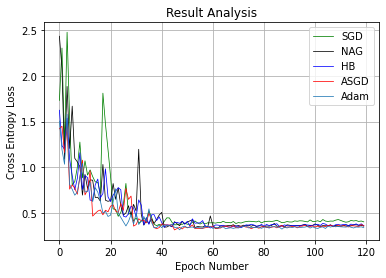

In [12]:
import matplotlib.pyplot as plt

#Create array of epochs for X axis
x_axis = np.zeros((120,1))
for i in range(120):
  x_axis[i] = i

#Plot Validation Loss for each algorithm
plt.title('Result Analysis')
plt.plot(x_axis, valid_loss_SGD, color='green', linewidth = 0.75,label='SGD')
plt.plot(x_axis, valid_loss_NAG[:], color='black', label='NAG', linewidth = 0.75,)
plt.plot(x_axis, valid_loss_HeavyBall[:], color='blue', label='HB', linewidth = 0.75,)
plt.plot(x_axis, valid_loss_ASGD[:], color='red', label='ASGD', linewidth = 0.75,)
plt.plot(x_axis, valid_loss_Adam[:], label='Adam', linewidth = 0.75,)

plt.legend()
 
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy Loss')
plt.grid(axis='both')
plt.savefig('Resnet128_decayed_validloss.png')
plt.show()


In [ ]:
from google.colab import files
files.download("Resnet128_decayed_validloss.png")

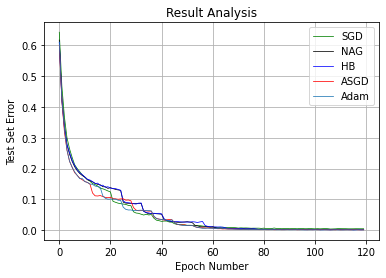

In [13]:
import matplotlib.pyplot as plt

#Create array of epochs for X axis
x_axis = np.zeros((120,1))
for i in range(120):
  x_axis[i] = i

#Plot Test Error for each algorithm
plt.title('Result Analysis')
plt.plot(x_axis, 1-train_accuracy_SGD[:], color='green', linewidth = 0.75,label='SGD')
plt.plot(x_axis, 1-train_accuracy_NAG[:], color='black', label='NAG', linewidth = 0.75,)
plt.plot(x_axis, 1-train_accuracy_HeavyBall[:], color='blue', label='HB', linewidth = 0.75,)
plt.plot(x_axis, 1-train_accuracy_ASGD[:], color='red', label='ASGD', linewidth = 0.75,)
plt.plot(x_axis, 1-train_accuracy_Adam[:], label='Adam', linewidth = 0.75,)

plt.legend()
 
plt.xlabel('Epoch Number')
plt.ylabel('Test Set Error')
plt.grid(axis='both')
plt.savefig('Resnet128_decayed_test_error.png')
plt.show()


In [ ]:
files.download('Resnet128_decayed_test_error.png')

#Fixed Hyperparameter Schedule

## SGD

In [ ]:
def fixed_stats_SGD(learning_rate, epochs, change):

  #Load PreResnet44
  model = Resnet(ResnetBlock, 44, num_classes)
  model.eval()

  #Initialise all the metrics to be saved
  train_loss_SGD = np.zeros(epochs)
  train_accuracy_SGD = np.zeros(epochs)
  valid_loss_SGD = np.zeros(epochs)
  valid_accuracy_SGD = np.zeros(epochs)
  test_accuracy_SGD = np.zeros(epochs)
  test_loss_SGD = np.zeros(epochs)

  loss_function = nn.CrossEntropyLoss()
  device = "cuda:0" 

  i = 0

  #Initilise validation loss as criteria at change point
  loss = 100
  prev_loss = 100

  for epoch in range(epochs):

    #Creates a deep copy of the parameter and gradient tensors and makes them shareable to enable re-use of Resnet modules multiple times
    model = copy.deepcopy(model)
    optimiser = optim.SGD(model.parameters(), lr = learning_rate[i], weight_decay=0.0005)

    #Train the model on training data
    trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy'], verbose=0).to(device)
    trial.with_generators(train_loader, valid_loader, test_generator=test_loader)

    result = trial.run(epochs=1)

    #At change points, update the hyperparameters depending on whether validation loss reduced by more than 1% or not
    if epoch%change == 0:
      if ((prev_loss - loss)/prev_loss < 0.01 and i < 3 ) and epoch!=0:
        i = i + 1
    
      prev_loss = loss


    #Compute the metrics on Test Dataset
    test_metric = trial.evaluate(data_key=torchbearer.TEST_DATA)

    #Store the metrics at each epoch
    train_loss_SGD[epoch] = result[0]['loss']
    train_accuracy_SGD[epoch] = result[0]['acc']
    valid_loss_SGD[epoch] = result[0]['val_loss']
    valid_accuracy_SGD[epoch] = result[0]['val_acc']
    test_accuracy_SGD[epoch] = result[0]['test_acc']
    test_loss_SGD[epoch] = result[0]['test_loss']
    loss = result[0]['loss']

    print(epoch, learning_rate[i], result)

  return train_loss_SGD, train_accuracy_SGD, valid_loss_SGD, valid_accuracy_SGD, test_loss_SGD, test_accuracy_SGD

In [ ]:
epochs = 120
learning_rate = [0.27,0.09,0.03,0.01]
change = 4

train_loss_SGD, train_accuracy_SGD, valid_loss_SGD, valid_accuracy_SGD, test_loss_SGD, test_accuracy_SGD = fixed_stats_SGD(learning_rate, epochs, change)

###Load Precomputed Metrics

In [14]:
# # Uncomment the below lines to restore the pre computed metrics for SGD on Batch Size 128 and Fixed Hyperparameter Schedule

# train_loss_SGD = np.array([1.72328997, 1.28034222, 1.02524304, 0.85579467, 0.75539404,
#        0.68107015, 0.6236499 , 0.57963866, 0.54414594, 0.52074349,
#        0.49652776, 0.47239065, 0.45474711, 0.43356821, 0.42150345,
#        0.41060674, 0.3959339 , 0.38330072, 0.37902623, 0.36826918,
#        0.36458308, 0.35573462, 0.34390184, 0.3355068 , 0.32942462,
#        0.32474434, 0.31781265, 0.31708792, 0.31056657, 0.3042427 ,
#        0.30546883, 0.30007178, 0.29094127, 0.29428235, 0.28554115,
#        0.28313136, 0.28389776, 0.28350592, 0.27272734, 0.26988745,
#        0.2653487 , 0.2652441 , 0.26163745, 0.25682011, 0.2572757 ,
#        0.25776568, 0.25617465, 0.25326782, 0.2472717 , 0.24448702,
#        0.24276999, 0.24158126, 0.24219011, 0.24379313, 0.23772949,
#        0.23360313, 0.23707616, 0.23496374, 0.23154798, 0.22565027,
#        0.22894743, 0.22362641, 0.22181435, 0.22139284, 0.22362503,
#        0.21892039, 0.22059499, 0.22037318, 0.21662812, 0.12359381,
#        0.09181412, 0.08711926, 0.08222803, 0.07588276, 0.08008949,
#        0.07787126, 0.0735192 , 0.0733573 , 0.07251874, 0.07160074,
#        0.0747529 , 0.07253262, 0.0740836 , 0.07158894, 0.07620709,
#        0.04090399, 0.03011571, 0.02885712, 0.0254235 , 0.02266706,
#        0.02285781, 0.02033324, 0.02080745, 0.01859738, 0.0192175 ,
#        0.0187099 , 0.02019121, 0.01948284, 0.01663471, 0.01786587,
#        0.01615327, 0.01708952, 0.01760845, 0.01834076, 0.01740243,
#        0.01144316, 0.01041191, 0.0110108 , 0.01017185, 0.00969994,
#        0.00932523, 0.00868319, 0.00870176, 0.00831991, 0.0086712 ,
#        0.00764281, 0.00903481, 0.00806554, 0.00782344, 0.00789883])
# train_accuracy_SGD = np.array([0.35377499, 0.53402501, 0.63119996, 0.69852501, 0.73439997,
#        0.760625  , 0.78437495, 0.79727501, 0.81002498, 0.82162499,
#        0.82802498, 0.83627498, 0.84429997, 0.85089999, 0.85600001,
#        0.8585    , 0.86182499, 0.86722499, 0.86849999, 0.872675  ,
#        0.87434995, 0.87612498, 0.88152498, 0.88330001, 0.887375  ,
#        0.88589996, 0.89064997, 0.89092499, 0.89219999, 0.8951    ,
#        0.89424998, 0.89497501, 0.90027499, 0.89794999, 0.9016    ,
#        0.90139997, 0.89999998, 0.90234995, 0.90539998, 0.90602499,
#        0.90732497, 0.90897501, 0.90849996, 0.91024995, 0.91125   ,
#        0.91009998, 0.91162497, 0.91207498, 0.91312498, 0.91452497,
#        0.91469997, 0.91579998, 0.91427499, 0.91562498, 0.91852498,
#        0.91842496, 0.917575  , 0.91822499, 0.92014998, 0.92109996,
#        0.91962498, 0.92232496, 0.92337495, 0.92389995, 0.92209995,
#        0.92434996, 0.92327499, 0.92264998, 0.92364997, 0.958525  ,
#        0.96914995, 0.97104996, 0.972525  , 0.97424996, 0.97324997,
#        0.97297496, 0.97582495, 0.97547495, 0.974675  , 0.97589999,
#        0.97454995, 0.97624999, 0.97472495, 0.97547495, 0.97427499,
#        0.9874    , 0.99147499, 0.99199998, 0.9932    , 0.994075  ,
#        0.99394995, 0.99507499, 0.99449998, 0.99544996, 0.99495   ,
#        0.99504995, 0.99414998, 0.9946    , 0.99537498, 0.99507499,
#        0.99589998, 0.995525  , 0.99524999, 0.99514997, 0.99527496,
#        0.99764997, 0.99799997, 0.99757499, 0.99752498, 0.99809998,
#        0.99799997, 0.99844998, 0.99817497, 0.99852496, 0.99827498,
#        0.99879998, 0.99807495, 0.99839997, 0.99852496, 0.99844998])
# valid_loss_SGD = np.array([1.91027474, 2.90158391, 1.33701563, 1.47734165, 1.20529318,
#        1.19040835, 0.95511472, 0.86554825, 2.44057703, 1.09310603,
#        1.11725736, 1.07295978, 1.21384883, 0.92050731, 0.91551471,
#        0.66391701, 0.8884173 , 0.85305303, 0.8323431 , 0.67318594,
#        1.01316047, 0.54284692, 0.60878634, 1.02722239, 0.61824822,
#        0.9322114 , 0.69519991, 0.83323085, 0.69108528, 0.8463726 ,
#        0.95900625, 0.53634518, 0.76449615, 0.92353332, 0.66677886,
#        0.73852283, 0.57437968, 0.61428571, 0.94161528, 0.5844844 ,
#        0.61660564, 0.81779432, 1.03912914, 2.2684598 , 1.09793031,
#        0.64922535, 0.67295313, 0.57434583, 0.66547406, 0.74894935,
#        0.48413908, 0.62966299, 0.62666821, 0.47451136, 0.6528275 ,
#        0.65953714, 0.58581996, 0.65979582, 0.45024684, 1.71934938,
#        0.79138261, 0.83330131, 0.53900814, 0.67211902, 1.10641682,
#        0.65837908, 0.60451162, 1.34738147, 0.93788123, 0.32431754,
#        0.3237319 , 0.40596497, 0.36983821, 0.40574738, 0.39500317,
#        0.40325722, 0.37776998, 0.37115857, 0.4544352 , 0.45537022,
#        0.37075287, 0.34635317, 0.36833486, 0.49164751, 0.47110856,
#        0.31626311, 0.32625198, 0.33833817, 0.33883595, 0.32720268,
#        0.34226695, 0.32315862, 0.328679  , 0.32018051, 0.34195212,
#        0.36777773, 0.34196314, 0.37061974, 0.34722975, 0.35289198,
#        0.36407742, 0.35999054, 0.3581436 , 0.35841548, 0.35257834,
#        0.34072092, 0.35215187, 0.3561326 , 0.33670306, 0.35312   ,
#        0.33465603, 0.34993514, 0.34276426, 0.34014884, 0.34501392,
#        0.34277698, 0.33865163, 0.36083001, 0.37353891, 0.35998371])
# valid_accuracy_SGD = np.array([0.352     , 0.28509998, 0.55379999, 0.52419996, 0.60170001,
#        0.61129999, 0.67899996, 0.70289999, 0.48499998, 0.66979998,
#        0.64059997, 0.66389996, 0.62159997, 0.70529997, 0.7137    ,
#        0.77899998, 0.70289999, 0.72409999, 0.74009997, 0.77939999,
#        0.70129997, 0.8168    , 0.78279996, 0.68720001, 0.79909998,
#        0.70660001, 0.7665    , 0.74829996, 0.77649999, 0.7331    ,
#        0.71759999, 0.81830001, 0.75239998, 0.70660001, 0.7942    ,
#        0.78059995, 0.81049997, 0.80879998, 0.72279996, 0.81599998,
#        0.80429995, 0.74289995, 0.71340001, 0.56040001, 0.70059997,
#        0.80249995, 0.78599995, 0.8247    , 0.78929996, 0.77349997,
#        0.84200001, 0.80689996, 0.80339998, 0.84869999, 0.80909997,
#        0.8021    , 0.80879998, 0.7913    , 0.84859997, 0.61179996,
#        0.76669997, 0.75529999, 0.82699996, 0.8028    , 0.70319998,
#        0.79229999, 0.80619997, 0.69709998, 0.73069996, 0.8976    ,
#        0.89849997, 0.88150001, 0.89029998, 0.88489997, 0.88169998,
#        0.88449997, 0.88510001, 0.89199996, 0.87909997, 0.87540001,
#        0.89159995, 0.89679998, 0.89129996, 0.86829996, 0.87009996,
#        0.90639997, 0.90859997, 0.90779996, 0.90509999, 0.91279995,
#        0.912     , 0.91179997, 0.91319996, 0.91359997, 0.91259998,
#        0.9091    , 0.90929997, 0.90719998, 0.91159999, 0.90889996,
#        0.91289997, 0.90819997, 0.90999997, 0.91119999, 0.91419995,
#        0.91429996, 0.91060001, 0.91119999, 0.91529995, 0.9156    ,
#        0.91589999, 0.91339999, 0.9149    , 0.91569996, 0.91419995,
#        0.91549999, 0.91749996, 0.912     , 0.9163    , 0.91569996])
# test_loss_SGD = np.array([1.73960614, 3.1996417 , 1.40677726, 1.45356357, 1.23150373,
#        1.2122252 , 0.95685703, 0.86330646, 2.49197364, 1.17764008,
#        1.17286038, 1.13336921, 1.20337701, 0.9085114 , 0.93988097,
#        0.67869639, 0.90758538, 0.85155517, 0.90659547, 0.6634891 ,
#        1.17116046, 0.51833975, 0.62781221, 1.08211303, 0.63777   ,
#        1.01391995, 0.68476027, 0.86100841, 0.72534996, 0.89138865,
#        1.00867093, 0.51678312, 0.79990423, 1.02534902, 0.6862939 ,
#        0.76171464, 0.5573982 , 0.62439913, 1.01014984, 0.60724139,
#        0.62874985, 0.84259981, 1.12568092, 2.35537696, 1.24995983,
#        0.67104644, 0.71623415, 0.58379686, 0.71561205, 0.75700605,
#        0.44837147, 0.62851202, 0.61275887, 0.46967492, 0.64872015,
#        0.65285736, 0.56828934, 0.6373626 , 0.46719381, 1.97587991,
#        0.81944937, 0.94175106, 0.52848333, 0.66508681, 1.24658942,
#        0.66062558, 0.61226159, 1.32862103, 1.02601635, 0.32686201,
#        0.31931633, 0.41124916, 0.3488417 , 0.38273662, 0.41722775,
#        0.39730614, 0.39085594, 0.37718824, 0.46609357, 0.45315278,
#        0.37766597, 0.35028589, 0.37119508, 0.51432312, 0.50119776,
#        0.31679019, 0.32770976, 0.33715042, 0.33802903, 0.33189982,
#        0.34539971, 0.33819944, 0.33076322, 0.34035465, 0.34468725,
#        0.35146323, 0.34958407, 0.36170292, 0.34663108, 0.360414  ,
#        0.3697319 , 0.37769151, 0.36231092, 0.35074231, 0.35281596,
#        0.34845251, 0.36202264, 0.34519637, 0.34371382, 0.34745374,
#        0.34933931, 0.34950399, 0.35223982, 0.35107252, 0.35086918,
#        0.35127333, 0.35379073, 0.35364267, 0.35676816, 0.36380231])
# test_accuracy_SGD = np.array([0.39769998, 0.2922    , 0.5521    , 0.54170001, 0.59899998,
#        0.625     , 0.68549997, 0.71340001, 0.4887    , 0.66949999,
#        0.64410001, 0.65899998, 0.63739997, 0.72039998, 0.71129996,
#        0.78749996, 0.7177    , 0.73359996, 0.74619997, 0.7881    ,
#        0.68159997, 0.82519996, 0.78059995, 0.68470001, 0.79969996,
#        0.70419997, 0.78099996, 0.75269997, 0.78139997, 0.73659998,
#        0.722     , 0.82669997, 0.74449998, 0.6929    , 0.79449999,
#        0.78839999, 0.8193    , 0.81799996, 0.71810001, 0.8193    ,
#        0.80320001, 0.74949998, 0.71069998, 0.56549996, 0.68110001,
#        0.80599999, 0.78049999, 0.82709998, 0.78599995, 0.78099996,
#        0.8563    , 0.81149995, 0.81369996, 0.8502    , 0.81439996,
#        0.80659997, 0.81519997, 0.80249995, 0.8563    , 0.60420001,
#        0.76989996, 0.74619997, 0.83389997, 0.81209999, 0.69619995,
#        0.79829997, 0.81099999, 0.71539998, 0.72399998, 0.8987    ,
#        0.90139997, 0.88379997, 0.89649999, 0.89249998, 0.87949997,
#        0.88979995, 0.8865    , 0.89379996, 0.87720001, 0.8757    ,
#        0.89239997, 0.8994    , 0.89559996, 0.86859995, 0.86799997,
#        0.90979999, 0.91219997, 0.91259998, 0.91119999, 0.91189998,
#        0.91079998, 0.91229999, 0.91249996, 0.91219997, 0.91339999,
#        0.91209996, 0.91119999, 0.91209996, 0.91029996, 0.9113    ,
#        0.90929997, 0.90669996, 0.91049999, 0.91459996, 0.91279995,
#        0.912     , 0.91259998, 0.91529995, 0.91399997, 0.91479999,
#        0.91529995, 0.91539997, 0.9163    , 0.91589999, 0.91509998,
#        0.91670001, 0.9181    , 0.91799998, 0.91619998, 0.91529995])

In [ ]:
print("Training Loss Set: ", repr(train_loss_SGD))
print("Training Accuracy Set: ", repr(train_accuracy_SGD))
print("Validation Loss Set: ", repr(valid_loss_SGD))
print("Validation Accuracy Set: ",repr(valid_accuracy_SGD))
print("Test Loss Set: ", repr(test_loss_SGD))
print("Test Accuracy Set: ",repr(test_accuracy_SGD))

Training Loss Set:  array([1.72328997, 1.28034222, 1.02524304, 0.85579467, 0.75539404,
       0.68107015, 0.6236499 , 0.57963866, 0.54414594, 0.52074349,
       0.49652776, 0.47239065, 0.45474711, 0.43356821, 0.42150345,
       0.41060674, 0.3959339 , 0.38330072, 0.37902623, 0.36826918,
       0.36458308, 0.35573462, 0.34390184, 0.3355068 , 0.32942462,
       0.32474434, 0.31781265, 0.31708792, 0.31056657, 0.3042427 ,
       0.30546883, 0.30007178, 0.29094127, 0.29428235, 0.28554115,
       0.28313136, 0.28389776, 0.28350592, 0.27272734, 0.26988745,
       0.2653487 , 0.2652441 , 0.26163745, 0.25682011, 0.2572757 ,
       0.25776568, 0.25617465, 0.25326782, 0.2472717 , 0.24448702,
       0.24276999, 0.24158126, 0.24219011, 0.24379313, 0.23772949,
       0.23360313, 0.23707616, 0.23496374, 0.23154798, 0.22565027,
       0.22894743, 0.22362641, 0.22181435, 0.22139284, 0.22362503,
       0.21892039, 0.22059499, 0.22037318, 0.21662812, 0.12359381,
       0.09181412, 0.08711926, 0.08222803,

##Heavy Ball

In [ ]:
def fixed_stats_HeavyBall(learning_rate, momentum, epochs, change):

  #Load PreResnet44
  model = Resnet(ResnetBlock, 44, num_classes)
  model.eval()

  #Initialise all the metrics to be saved
  train_loss_HeavyBall = np.zeros(epochs)
  train_accuracy_HeavyBall = np.zeros(epochs)
  valid_loss_HeavyBall = np.zeros(epochs)
  valid_accuracy_HeavyBall = np.zeros(epochs)
  test_accuracy_HeavyBall = np.zeros(epochs)
  test_loss_HeavyBall = np.zeros(epochs)

  loss_function = nn.CrossEntropyLoss()
  device = "cuda:0" 

  i = 0
  m = 0

  loss = 100
  prev_loss = 100

  for epoch in range(epochs):

    model = copy.deepcopy(model)
    optimiser = optim.SGD(model.parameters(), lr = learning_rate[i], momentum = momentum[m], weight_decay=0.0005)

    #Train the model on training data
    trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy'],  verbose=0).to(device)
    trial.with_generators(train_loader, valid_loader, test_generator=test_loader)

    result = trial.run(epochs=1)

    #At change points, update the hyperparameters depending on whether validation loss reduced by more than 1% or not
    if epoch%change == 0:
      if ((prev_loss - loss)/prev_loss < 0.01 and i < 3 ) and epoch!=0:
        if(m < 4):
          m = m+1
        else:
          m = 0
          i = i+1

      prev_loss = loss

    #Compute the metrics on Test Dataset
    trial.evaluate(data_key=torchbearer.TEST_DATA)

    #Store the metrics at each epoch
    train_loss_HeavyBall[epoch] = result[0]['loss']
    train_accuracy_HeavyBall[epoch] = result[0]['acc']
    valid_loss_HeavyBall[epoch] = result[0]['val_loss']
    valid_accuracy_HeavyBall[epoch] = result[0]['val_acc']
    test_accuracy_HeavyBall[epoch] = result[0]['test_acc']
    test_loss_HeavyBall[epoch] = result[0]['test_loss']
    loss = result[0]['loss']

    error = 1 - result[0]['val_acc']

    print(epoch, learning_rate[i], momentum[m], result)

  return train_loss_HeavyBall, train_accuracy_HeavyBall, valid_loss_HeavyBall, valid_accuracy_HeavyBall, test_loss_HeavyBall, test_accuracy_HeavyBall

In [ ]:
epochs = 120
learning_rate = [0.27,0.09,0.03,0.01]
momentum = [0.97,0.95,0.9,0.8,0.5]
change = 4

train_loss_HeavyBall, train_accuracy_HeavyBall, valid_loss_HeavyBall, valid_accuracy_HeavyBall, test_loss_HeavyBall, test_accuracy_HeavyBall = fixed_stats_HeavyBall(learning_rate, momentum, epochs, change)

0 0.27 0.97 [{'running_loss': 1.670586109161377, 'running_acc': 0.3631249964237213, 'loss': 1.8257654905319214, 'acc': 0.3112500011920929, 'val_loss': 1.9710627794265747, 'val_acc': 0.3012000024318695, 'train_steps': 313, 'validation_steps': 79, 'test_loss': 2.129056692123413, 'test_acc': 0.2802000045776367}]
1 0.27 0.97 [{'running_loss': 1.4853495359420776, 'running_acc': 0.4593749940395355, 'loss': 1.5664836168289185, 'acc': 0.41887497901916504, 'val_loss': 1.7063645124435425, 'val_acc': 0.4171999990940094, 'train_steps': 313, 'validation_steps': 79, 'test_loss': 1.6810295581817627, 'test_acc': 0.4258999824523926}]
2 0.27 0.97 [{'running_loss': 1.360421895980835, 'running_acc': 0.5021874904632568, 'loss': 1.4071134328842163, 'acc': 0.4841499924659729, 'val_loss': 1.912689208984375, 'val_acc': 0.3335999846458435, 'train_steps': 313, 'validation_steps': 79, 'test_loss': 1.918276071548462, 'test_acc': 0.35510000586509705}]
3 0.27 0.97 [{'running_loss': 1.26224684715271, 'running_acc': 0

###Load Precomputed Metrics

In [15]:
# # Uncomment the below lines to restore the pre computed metrics for Heavy Ball on Batch Size 128 and Fixed Hyperparameter Schedule

# train_loss_HeavyBall = np.array([1.82582533, 1.58168995, 1.39923131, 1.30678999, 1.24577391,
#        1.20475149, 1.15230918, 1.15069234, 1.13610911, 1.13038933,
#        1.11736774, 1.10061288, 1.09278047, 1.0895834 , 1.08071959,
#        1.09663808, 1.08669841, 0.9973284 , 0.96395904, 0.96136051,
#        0.94820446, 0.95224327, 0.94251823, 0.92623061, 0.94187647,
#        0.94237137, 0.92952615, 0.92424464, 0.93340695, 0.78451461,
#        0.78118497, 0.78193796, 0.76802731, 0.76924407, 0.77931899,
#        0.76204181, 0.7614789 , 0.76595581, 0.76314396, 0.75671583,
#        0.75856388, 0.6424455 , 0.63427478, 0.63983202, 0.64721042,
#        0.64317274, 0.63439983, 0.64050406, 0.63505799, 0.52279359,
#        0.50445884, 0.50628895, 0.50306624, 0.50731665, 0.50842243,
#        0.51166743, 0.50944424, 0.83593124, 0.75981706, 0.75622088,
#        0.76503295, 0.66682565, 0.65993345, 0.67684996, 0.6742425 ,
#        0.6628105 , 0.66725326, 0.6724391 , 0.66519988, 0.5674566 ,
#        0.55653054, 0.55615294, 0.55982661, 0.56254095, 0.55800951,
#        0.56380552, 0.56013465, 0.47910339, 0.46352682, 0.4655025 ,
#        0.46625432, 0.46766359, 0.4667955 , 0.46550655, 0.46989211,
#        0.39415073, 0.38187891, 0.37461978, 0.37329814, 0.37232041,
#        0.37375495, 0.37484014, 0.37331378, 0.64056194, 0.58544505,
#        0.5757165 , 0.57121193, 0.49576974, 0.48589569, 0.48542079,
#        0.48758218, 0.48392385, 0.48824647, 0.4893434 , 0.48108035,
#        0.41435134, 0.40890399, 0.40477708, 0.40385327, 0.40160975,
#        0.40383354, 0.41171306, 0.40440843, 0.35087079, 0.34288192,
#        0.33894122, 0.335747  , 0.33814135, 0.33768031, 0.33760607])
# train_accuracy_HeavyBall = np.array([0.30614999, 0.41167498, 0.49002498, 0.527825  , 0.55197501,
#        0.56862497, 0.59227496, 0.59347498, 0.59852499, 0.60034996,
#        0.60664999, 0.61194998, 0.61645001, 0.61504996, 0.62105   ,
#        0.61497498, 0.61932498, 0.653175  , 0.6631    , 0.66492498,
#        0.67092496, 0.66899997, 0.674775  , 0.68004996, 0.67242497,
#        0.67172498, 0.67887497, 0.67992496, 0.67667496, 0.73082501,
#        0.73097497, 0.73149997, 0.73460001, 0.73729998, 0.73107499,
#        0.73717499, 0.73614997, 0.73565   , 0.73612499, 0.74175   ,
#        0.73979998, 0.77875   , 0.78147501, 0.77947497, 0.77757496,
#        0.77819997, 0.78525001, 0.77794999, 0.78079998, 0.82077497,
#        0.82792497, 0.82429999, 0.82662499, 0.825225  , 0.82817501,
#        0.82387495, 0.82432497, 0.71169996, 0.73947495, 0.7396    ,
#        0.73552495, 0.77057499, 0.77405   , 0.76519996, 0.76792496,
#        0.77477497, 0.77152497, 0.76804996, 0.76867497, 0.80599999,
#        0.80884999, 0.80925   , 0.80789995, 0.80412495, 0.81077498,
#        0.8035    , 0.80732501, 0.83529997, 0.84217501, 0.83959997,
#        0.83812499, 0.83969998, 0.83802497, 0.84064996, 0.8398    ,
#        0.86422497, 0.86815   , 0.87182498, 0.87184995, 0.87297499,
#        0.87159997, 0.86989999, 0.87097496, 0.77732497, 0.79749995,
#        0.80067497, 0.80484998, 0.828825  , 0.83204997, 0.83342499,
#        0.83162498, 0.8344    , 0.8326    , 0.83177495, 0.83704996,
#        0.85817498, 0.8599    , 0.86062497, 0.86072499, 0.86149997,
#        0.86212498, 0.85879999, 0.86102498, 0.87902498, 0.88164997,
#        0.88414997, 0.8836    , 0.88365   , 0.88489997, 0.88474995])
# valid_loss_HeavyBall = np.array([2.75018811, 1.71574962, 2.82945132, 1.67079818, 1.51998734,
#        1.35055864, 1.5005182 , 1.59392488, 1.86635625, 1.45086718,
#        1.86573184, 1.78719735, 1.35344374, 1.47723353, 1.42669988,
#        1.62422836, 1.3200742 , 1.5677439 , 1.20499814, 1.33391452,
#        1.28864527, 1.59699643, 1.06963634, 1.69916105, 1.25193691,
#        1.4373771 , 1.55796218, 1.19350362, 1.498824  , 1.66483939,
#        1.72013974, 1.02347434, 1.12083006, 0.96412534, 1.97713792,
#        0.95503354, 1.68282676, 1.16746569, 1.06812012, 1.08315814,
#        1.64720309, 0.8370406 , 1.57659757, 1.07713127, 1.41967869,
#        0.85526097, 0.81355482, 0.77708638, 0.90235138, 0.79171318,
#        1.17479622, 0.80716544, 0.66334903, 0.72195113, 0.73263597,
#        0.65575373, 1.07714188, 0.99840009, 1.05240011, 1.3641336 ,
#        1.3131026 , 0.92533088, 0.8629145 , 0.94274199, 0.99632567,
#        0.74606532, 0.97323149, 0.89409715, 0.94344747, 0.68216556,
#        0.88259184, 1.05609894, 0.7400983 , 0.66551208, 0.88437629,
#        0.77810854, 0.76362461, 0.78451025, 0.70405829, 0.64511526,
#        0.78695023, 0.69542724, 0.80927408, 0.67400056, 0.69772375,
#        0.5244168 , 0.49595603, 0.56116271, 0.50989813, 0.58840936,
#        0.48597398, 0.5034492 , 0.58486122, 1.30136979, 0.70722312,
#        0.76770318, 0.74271905, 0.60686648, 0.64306897, 0.69252461,
#        0.63040173, 0.63787889, 0.70988756, 0.6128006 , 0.66330993,
#        0.53000087, 0.51877803, 0.52279437, 0.56888777, 0.64979422,
#        0.56340659, 0.64236939, 0.64344418, 0.46631354, 0.46541727,
#        0.52231848, 0.49729848, 0.47529858, 0.53127128, 0.48384762])
# valid_accuracy_HeavyBall = np.array([0.20799999, 0.39209998, 0.30359998, 0.42559999, 0.49829999,
#        0.50339997, 0.4795    , 0.39139998, 0.38839999, 0.49719998,
#        0.42449999, 0.46429998, 0.51889998, 0.5011    , 0.50369996,
#        0.45619997, 0.50819999, 0.4937    , 0.59119999, 0.5237    ,
#        0.542     , 0.51099998, 0.63510001, 0.48709998, 0.57839996,
#        0.4966    , 0.52450001, 0.59619999, 0.53469998, 0.49409997,
#        0.4761    , 0.64969999, 0.63080001, 0.68049997, 0.41249999,
#        0.66609997, 0.51499999, 0.61379999, 0.64109999, 0.63529998,
#        0.50940001, 0.7141    , 0.55000001, 0.65419996, 0.55769998,
#        0.71039999, 0.72060001, 0.73689997, 0.70109999, 0.73710001,
#        0.62519997, 0.74000001, 0.77449995, 0.7568    , 0.74799997,
#        0.7723    , 0.66289997, 0.65869999, 0.64849997, 0.54729998,
#        0.5686    , 0.67449999, 0.71249998, 0.67680001, 0.65450001,
#        0.74659997, 0.6656    , 0.6947    , 0.6918    , 0.76379997,
#        0.71429998, 0.67949998, 0.74349999, 0.77069998, 0.70129997,
#        0.74430001, 0.73979998, 0.73829997, 0.76139998, 0.7798    ,
#        0.74239999, 0.76409996, 0.74589998, 0.76669997, 0.77059996,
#        0.82249999, 0.83019996, 0.8125    , 0.82299995, 0.80189997,
#        0.83399999, 0.82440001, 0.8053    , 0.63599998, 0.7572    ,
#        0.73369998, 0.74979997, 0.79399997, 0.77849996, 0.76419997,
#        0.77709997, 0.78259999, 0.76679999, 0.7863    , 0.7773    ,
#        0.81879997, 0.8233    , 0.8251    , 0.80479997, 0.78119999,
#        0.80849999, 0.78689998, 0.78179997, 0.83699995, 0.8409    ,
#        0.82319999, 0.83089995, 0.8355    , 0.82269996, 0.83329999])
# test_loss_HeavyBall = np.array([2.74179173, 1.75287473, 3.07684326, 1.66542828, 1.6060313 ,
#        1.29601538, 1.45933628, 1.57044959, 1.9494828 , 1.62056518,
#        2.00086713, 2.00789905, 1.34460735, 1.51407778, 1.45495141,
#        1.6372838 , 1.27623105, 1.67650211, 1.30552137, 1.30648541,
#        1.39581752, 1.83174026, 1.09985185, 1.91959083, 1.25591981,
#        1.44279265, 1.81299138, 1.2626332 , 1.58753943, 1.82634687,
#        2.0316608 , 1.01529932, 1.09081006, 0.96806842, 2.43224931,
#        0.91154557, 1.74833429, 1.13037527, 1.10703218, 1.07996321,
#        1.89260948, 0.87819761, 1.80436265, 1.14946258, 1.62617826,
#        0.89227587, 0.84031039, 0.76795983, 0.95325434, 0.81576127,
#        1.18194163, 0.81524295, 0.65284812, 0.73307592, 0.742154  ,
#        0.64761269, 1.15048075, 0.99831086, 1.02474368, 1.43347633,
#        1.36855435, 0.92907494, 0.90467489, 0.93781662, 1.05845714,
#        0.74948651, 0.97597224, 0.93465078, 0.99331474, 0.71608913,
#        0.91050094, 1.08397138, 0.71614873, 0.66705269, 0.90904778,
#        0.75948304, 0.79614133, 0.82423121, 0.66915214, 0.62035006,
#        0.81625408, 0.70987481, 0.85915172, 0.69067127, 0.66868514,
#        0.49275985, 0.4859468 , 0.56619066, 0.49297449, 0.59493667,
#        0.46615052, 0.46949875, 0.57139391, 1.38618505, 0.72877169,
#        0.7900818 , 0.73295993, 0.59616953, 0.59902412, 0.66518527,
#        0.63826698, 0.63722199, 0.71509445, 0.61317974, 0.63622242,
#        0.52252167, 0.50228447, 0.50524068, 0.56495982, 0.62952518,
#        0.54806602, 0.63784623, 0.62172896, 0.45037249, 0.44499189,
#        0.49145675, 0.48417288, 0.46379796, 0.50466675, 0.46626917])
# test_accuracy_HeavyBall = np.array([0.23099999, 0.41099998, 0.3021    , 0.45099998, 0.50489998,
#        0.51159996, 0.4991    , 0.4179    , 0.39469999, 0.4788    ,
#        0.43109998, 0.44589999, 0.52450001, 0.51480001, 0.51749998,
#        0.47409999, 0.52099997, 0.49629998, 0.59209996, 0.54710001,
#        0.53069997, 0.493     , 0.64139998, 0.486     , 0.5869    ,
#        0.51249999, 0.50819999, 0.59619999, 0.53560001, 0.49899998,
#        0.46059999, 0.65939999, 0.65209997, 0.6807    , 0.39069998,
#        0.6825    , 0.52999997, 0.63529998, 0.64449996, 0.6372    ,
#        0.4901    , 0.7026    , 0.5438    , 0.65929997, 0.53359997,
#        0.71349996, 0.71829998, 0.74649996, 0.70169997, 0.7428    ,
#        0.64050001, 0.74559999, 0.78329998, 0.7615    , 0.74899995,
#        0.77889997, 0.6627    , 0.66299999, 0.6649    , 0.5449    ,
#        0.56999999, 0.68129998, 0.70599997, 0.68939996, 0.64179999,
#        0.7471    , 0.67739999, 0.69569999, 0.69389999, 0.76309997,
#        0.70959997, 0.6904    , 0.74989998, 0.77489996, 0.704     ,
#        0.75309998, 0.74759996, 0.7392    , 0.76809996, 0.79189998,
#        0.73789996, 0.76569998, 0.74419999, 0.77249998, 0.77770001,
#        0.8362    , 0.83569998, 0.81869996, 0.83579999, 0.80259997,
#        0.84079999, 0.84149998, 0.81189996, 0.648     , 0.76010001,
#        0.7349    , 0.75299996, 0.80089998, 0.796     , 0.77899998,
#        0.78819996, 0.78679997, 0.76339996, 0.79229999, 0.78709996,
#        0.82569999, 0.83309996, 0.83159995, 0.81229997, 0.79449999,
#        0.81449997, 0.78389996, 0.79579997, 0.8488    , 0.84569997,
#        0.833     , 0.83889997, 0.84279996, 0.83599997, 0.84200001])

In [ ]:
print("Training Loss Set: ",repr(train_loss_HeavyBall))
print("Training Accuracy Set: ",repr(train_accuracy_HeavyBall))
print("Validation Loss Set: ", repr(valid_loss_HeavyBall))
print("Validation Accuracy Set: ",repr(valid_accuracy_HeavyBall))
print("Test Loss Set: ", repr(test_loss_HeavyBall))
print("Test Accuracy Set: ",repr(test_accuracy_HeavyBall))

Training Loss Set:  array([1.82582533, 1.58168995, 1.39923131, 1.30678999, 1.24577391,
       1.20475149, 1.15230918, 1.15069234, 1.13610911, 1.13038933,
       1.11736774, 1.10061288, 1.09278047, 1.0895834 , 1.08071959,
       1.09663808, 1.08669841, 0.9973284 , 0.96395904, 0.96136051,
       0.94820446, 0.95224327, 0.94251823, 0.92623061, 0.94187647,
       0.94237137, 0.92952615, 0.92424464, 0.93340695, 0.78451461,
       0.78118497, 0.78193796, 0.76802731, 0.76924407, 0.77931899,
       0.76204181, 0.7614789 , 0.76595581, 0.76314396, 0.75671583,
       0.75856388, 0.6424455 , 0.63427478, 0.63983202, 0.64721042,
       0.64317274, 0.63439983, 0.64050406, 0.63505799, 0.52279359,
       0.50445884, 0.50628895, 0.50306624, 0.50731665, 0.50842243,
       0.51166743, 0.50944424, 0.83593124, 0.75981706, 0.75622088,
       0.76503295, 0.66682565, 0.65993345, 0.67684996, 0.6742425 ,
       0.6628105 , 0.66725326, 0.6724391 , 0.66519988, 0.5674566 ,
       0.55653054, 0.55615294, 0.55982661,

## NAG

In [ ]:
def fixed_stats_NAG(learning_rate, momentum, epochs, change):

  #Load PreResnet44
  model = Resnet(ResnetBlock, 44, num_classes)
  model.eval()

  #Initialise all the metrics to be saved
  train_loss_NAG = np.zeros(epochs)
  train_accuracy_NAG = np.zeros(epochs)
  valid_loss_NAG = np.zeros(epochs)
  valid_accuracy_NAG = np.zeros(epochs)
  test_accuracy_NAG = np.zeros(epochs)
  test_loss_NAG = np.zeros(epochs)

  loss_function = nn.CrossEntropyLoss()
  device = "cuda:0" 

  i = 0
  m = 0

  loss = 100
  prev_loss = 100

  for epoch in range(epochs):

      model = copy.deepcopy(model)
      optimiser = optim.SGD(model.parameters(), lr = learning_rate[i], momentum = momentum[m], nesterov = True, weight_decay=0.0005)

      #Train the model on training data
      trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy'],  verbose=0).to(device)
      trial.with_generators(train_loader, valid_loader, test_generator=test_loader)

      result = trial.run(epochs=1)

      #At change points, update the hyperparameters depending on whether validation loss reduced by more than 1% or not
      if epoch%change == 0:
        if ((prev_loss - loss)/prev_loss < 0.01 and i < 3 ) and epoch!=0:
          if(m < 4):
            m = m+1
          else:
            m = 0
            i = i+1

        prev_loss = loss

      #Compute the metrics on Test Dataset
      trial.evaluate(data_key=torchbearer.TEST_DATA)

      #Store the metrics at each epoch
      train_loss_NAG[epoch] = result[0]['loss']
      train_accuracy_NAG[epoch] = result[0]['acc']
      valid_loss_NAG[epoch] = result[0]['val_loss']
      valid_accuracy_NAG[epoch] = result[0]['val_acc']
      test_accuracy_NAG[epoch] = result[0]['test_acc']
      test_loss_NAG[epoch] = result[0]['test_loss']
      loss = result[0]['loss']


      print(epoch, learning_rate[i], momentum[m], result)
    
  return train_loss_NAG, train_accuracy_NAG, valid_loss_NAG, valid_accuracy_NAG, test_loss_NAG, test_accuracy_NAG


In [ ]:
epochs = 120
learning_rate = [0.27,0.09,0.03,0.01]
momentum = [0.97,0.95,0.9,0.8,0.5]
change = 4

train_loss_NAG, train_accuracy_NAG, valid_loss_NAG, valid_accuracy_NAG, test_loss_NAG, test_accuracy_NAG = fixed_stats_NAG(learning_rate, momentum, epochs, change)

0 0.27 0.95 [{'running_loss': 1.5221710205078125, 'running_acc': 0.44484373927116394, 'loss': 1.7225241661071777, 'acc': 0.351749986410141, 'val_loss': 1.6869374513626099, 'val_acc': 0.3894999921321869, 'train_steps': 313, 'validation_steps': 79, 'test_loss': 1.6687885522842407, 'test_acc': 0.4007999897003174}]
1 0.27 0.95 [{'running_loss': 1.239623785018921, 'running_acc': 0.5553125143051147, 'loss': 1.325116753578186, 'acc': 0.5214250087738037, 'val_loss': 1.5309624671936035, 'val_acc': 0.46789997816085815, 'train_steps': 313, 'validation_steps': 79, 'test_loss': 1.5332467555999756, 'test_acc': 0.4747999906539917}]


KeyboardInterrupt: ignored

###Load Precomputed Metrics

In [16]:
# # Uncomment the below lines to restore the pre computed metrics for NAG on Batch Size 128 and Fixed Hyperparameter Schedule

# train_loss_NAG = np.array([1.73338771, 1.4242115 , 1.21844304, 1.11848581, 1.0591284 ,
#        1.01552749, 0.98649102, 0.97336596, 0.9614445 , 0.9584446 ,
#        0.94488478, 0.94360769, 0.94525474, 0.92986143, 0.92368215,
#        0.93611127, 0.92799252, 0.85230649, 0.84374267, 0.8415367 ,
#        0.82996804, 0.82943177, 0.82744688, 0.82265061, 0.81849867,
#        0.81851614, 0.81384581, 0.82229865, 0.81172585, 0.70236778,
#        0.70809519, 0.70773369, 0.69817114, 0.69955695, 0.69094896,
#        0.69388652, 0.68654251, 0.69028699, 0.68416899, 0.67945319,
#        0.6780476 , 0.67942011, 0.67831963, 0.6791178 , 0.67613959,
#        0.5844835 , 0.57318068, 0.58231622, 0.57926208, 0.57766259,
#        0.57934886, 0.57532656, 0.57100379, 0.57282072, 0.57126594,
#        0.57494515, 0.56606013, 0.4678005 , 0.45349282, 0.45693427,
#        0.4541384 , 0.45923737, 0.45904008, 0.45859754, 0.45347667,
#        0.72985739, 0.67406756, 0.67574579, 0.66668147, 0.60578072,
#        0.59581637, 0.59140903, 0.59334481, 0.59609032, 0.59206969,
#        0.5974707 , 0.5906018 , 0.507186  , 0.4911494 , 0.49957553,
#        0.49947938, 0.49660093, 0.5024088 , 0.50187767, 0.50263739,
#        0.42367339, 0.41739804, 0.41319108, 0.41377112, 0.41634429,
#        0.41554892, 0.41849345, 0.413771  , 0.34611648, 0.33432186,
#        0.33019835, 0.32444507, 0.32596794, 0.32405451, 0.32920766,
#        0.32449937, 0.55416822, 0.51960701, 0.51276314, 0.49936682,
#        0.44007644, 0.4252139 , 0.43075916, 0.43269679, 0.43062127,
#        0.43362704, 0.43290573, 0.42693692, 0.36850327, 0.35642675,
#        0.35430402, 0.35387355, 0.35408956, 0.35357308, 0.35464114])
# train_accuracy_NAG = np.array([0.35387498, 0.47849998, 0.56559998, 0.60482496, 0.62547499,
#        0.64487499, 0.65354997, 0.66062498, 0.662875  , 0.66609997,
#        0.6681    , 0.67102498, 0.67062497, 0.67369998, 0.67927498,
#        0.67264998, 0.67659998, 0.70239997, 0.708125  , 0.70737499,
#        0.712125  , 0.7119    , 0.71237499, 0.71424997, 0.71529996,
#        0.71774995, 0.719675  , 0.71547496, 0.71884996, 0.75439996,
#        0.75672495, 0.75799996, 0.75929999, 0.75919998, 0.76232499,
#        0.76069999, 0.76545   , 0.76344997, 0.76497495, 0.76444995,
#        0.7669    , 0.76504999, 0.76620001, 0.76577497, 0.76567501,
#        0.79964995, 0.804775  , 0.79897499, 0.80052495, 0.80237496,
#        0.80119997, 0.801875  , 0.80355   , 0.80204999, 0.80339998,
#        0.80282497, 0.80504996, 0.8387    , 0.84447497, 0.84284997,
#        0.84542495, 0.84329998, 0.842875  , 0.84334999, 0.84454995,
#        0.74627501, 0.76894999, 0.7683    , 0.77212501, 0.79237497,
#        0.79427499, 0.796175  , 0.79522496, 0.79492497, 0.79664999,
#        0.79604995, 0.79804999, 0.82604998, 0.83054996, 0.82979995,
#        0.82709998, 0.82842499, 0.82685   , 0.82652497, 0.830275  ,
#        0.85412496, 0.85724998, 0.85819995, 0.85822499, 0.85897499,
#        0.85817498, 0.85619998, 0.85802495, 0.88249999, 0.88622499,
#        0.88592499, 0.88879997, 0.88769996, 0.88839996, 0.8876    ,
#        0.888825  , 0.81084996, 0.81989998, 0.82419997, 0.8272    ,
#        0.84797496, 0.855775  , 0.85197496, 0.85132498, 0.853275  ,
#        0.85172498, 0.84982497, 0.85289997, 0.874075  , 0.87747496,
#        0.879125  , 0.8775    , 0.87847495, 0.87822497, 0.87852496])
# valid_loss_NAG = np.array([1.85914195, 1.55069399, 3.17015314, 1.46516347, 2.14150524,
#        1.29717231, 1.31080997, 2.39367342, 1.20235109, 1.57869458,
#        1.16446877, 1.4756912 , 1.44670713, 1.10402012, 1.29759765,
#        1.25296223, 1.21646357, 1.28301597, 1.38205779, 1.57219183,
#        1.45331717, 1.46534216, 2.70419073, 0.99877912, 1.0893333 ,
#        1.08502185, 1.25983834, 1.24727082, 1.53747988, 1.05223846,
#        1.3384304 , 1.031358  , 0.94328618, 1.30655658, 2.00255942,
#        0.92747712, 1.71909225, 1.16007221, 0.95391047, 1.69136202,
#        0.84510875, 1.03460085, 1.31677055, 0.96936607, 1.02762997,
#        0.92504972, 0.79860371, 0.92005742, 0.85643828, 1.21276188,
#        1.01504862, 0.73683661, 0.69276434, 1.25804102, 1.09864831,
#        0.87899321, 0.91368151, 0.67302036, 0.76143157, 0.67963552,
#        1.17777836, 0.72837108, 1.05508161, 0.69455612, 0.8681187 ,
#        1.00231719, 0.92101848, 0.8922748 , 0.77316874, 0.79222792,
#        0.79708672, 0.88485461, 0.88883287, 0.8090536 , 0.77091044,
#        0.72101969, 1.07084012, 0.70539838, 0.64415777, 0.60887653,
#        0.81925261, 0.81279069, 0.84143907, 0.68309361, 0.71767855,
#        0.57684261, 0.55087727, 0.6228283 , 0.73353803, 0.63821566,
#        0.75288618, 0.68878907, 0.59955949, 0.48526102, 0.46917963,
#        0.55068713, 0.60399485, 0.61787361, 0.75852507, 0.67747831,
#        0.49872074, 0.72838259, 0.68957919, 0.64515311, 0.62788814,
#        0.54031849, 0.61020958, 0.61913544, 0.54472554, 0.75594074,
#        0.66069543, 0.78973335, 0.67817128, 0.54680735, 0.57065672,
#        0.56189889, 0.53532857, 0.50061339, 0.49794775, 0.48155454])
# valid_accuracy_NAG = np.array([0.3328    , 0.43879998, 0.23369999, 0.52059996, 0.35079998,
#        0.56079996, 0.55540001, 0.40369999, 0.57819998, 0.48319998,
#        0.59359998, 0.48199999, 0.49139997, 0.6257    , 0.55320001,
#        0.59539998, 0.5751    , 0.58270001, 0.5485    , 0.52679998,
#        0.53279996, 0.55329996, 0.37019998, 0.65619999, 0.61979997,
#        0.62519997, 0.5909    , 0.60879999, 0.52389997, 0.6591    ,
#        0.57819998, 0.63879997, 0.68439996, 0.59189999, 0.4418    ,
#        0.68970001, 0.54109997, 0.6056    , 0.67619997, 0.51629996,
#        0.70840001, 0.64019996, 0.58849996, 0.66639996, 0.66139996,
#        0.70059997, 0.74180001, 0.69629997, 0.70999998, 0.60299999,
#        0.68799996, 0.74109995, 0.76199996, 0.60710001, 0.65469998,
#        0.70379996, 0.69699997, 0.77590001, 0.7475    , 0.77129996,
#        0.60969996, 0.74449998, 0.6591    , 0.75769997, 0.72509998,
#        0.66229999, 0.6753    , 0.70089996, 0.72939998, 0.72719997,
#        0.72399998, 0.70899999, 0.70879996, 0.72889996, 0.73100001,
#        0.75199997, 0.64989996, 0.75999999, 0.77950001, 0.79549998,
#        0.7414    , 0.73399997, 0.72359997, 0.76550001, 0.76269996,
#        0.8028    , 0.81699997, 0.79189998, 0.75379997, 0.78709996,
#        0.75239998, 0.77359998, 0.79960001, 0.83569998, 0.84169996,
#        0.81399995, 0.79409999, 0.79439998, 0.74519998, 0.77379996,
#        0.83129996, 0.7536    , 0.76879996, 0.78499997, 0.78490001,
#        0.8168    , 0.79339999, 0.79079998, 0.81479996, 0.74619997,
#        0.77739996, 0.74449998, 0.77599996, 0.8161    , 0.80219996,
#        0.80919999, 0.82059997, 0.82549995, 0.83339995, 0.83819997])
# test_loss_NAG = np.array([1.80646062, 1.49461091, 3.34948468, 1.61990237, 2.44534111,
#        1.35324061, 1.26141644, 2.67190409, 1.20533919, 1.56957066,
#        1.21479428, 1.49359822, 1.4887495 , 1.09147072, 1.28641927,
#        1.28524613, 1.18578088, 1.26930737, 1.41208076, 1.66762745,
#        1.44575405, 1.5144136 , 3.15103221, 0.9667297 , 1.08334851,
#        1.01309741, 1.34350908, 1.37422395, 1.64784014, 1.07348871,
#        1.49413192, 1.02711213, 0.93975526, 1.50784814, 2.64408159,
#        0.94504106, 1.96167517, 1.1734376 , 1.0501616 , 1.98579645,
#        0.82971668, 1.06618285, 1.39204395, 1.03007996, 1.08641613,
#        0.96000749, 0.80575633, 0.95454252, 0.91730183, 1.31744874,
#        1.04923749, 0.70095038, 0.70138371, 1.27626026, 1.13230503,
#        0.94424999, 0.97144127, 0.70961219, 0.75948566, 0.686369  ,
#        1.30114269, 0.73789239, 1.14631152, 0.70972872, 0.88661516,
#        1.00001538, 0.94861317, 0.94737428, 0.78486478, 0.74667716,
#        0.80351865, 0.874071  , 0.92458421, 0.81814384, 0.73399168,
#        0.72474009, 1.13150156, 0.716717  , 0.61792511, 0.62335885,
#        0.8376072 , 0.89179212, 0.86634821, 0.65295482, 0.70569503,
#        0.56199485, 0.5682193 , 0.61573631, 0.72841734, 0.66310853,
#        0.75879401, 0.71755016, 0.62095988, 0.50446153, 0.45697245,
#        0.57699984, 0.61830425, 0.67246586, 0.81702852, 0.73237222,
#        0.49314895, 0.71838528, 0.70073241, 0.60956508, 0.63136923,
#        0.53167379, 0.60962433, 0.63218486, 0.53317827, 0.74996883,
#        0.7022354 , 0.82266325, 0.69184732, 0.52815533, 0.5890851 ,
#        0.56659091, 0.54695088, 0.48032787, 0.47146174, 0.45904446])
# test_accuracy_NAG = np.array([0.36609998, 0.45949998, 0.24599999, 0.5068    , 0.33759999,
#        0.56379998, 0.58789998, 0.39679998, 0.58709997, 0.5029    ,
#        0.58950001, 0.4799    , 0.49919999, 0.63749999, 0.574     ,
#        0.60429996, 0.5887    , 0.60899997, 0.55409998, 0.52810001,
#        0.55540001, 0.55949998, 0.37079999, 0.67129999, 0.62149996,
#        0.65020001, 0.59819996, 0.59729999, 0.52249998, 0.65859997,
#        0.57989997, 0.64209998, 0.68829995, 0.5826    , 0.41399997,
#        0.69379997, 0.53389996, 0.60460001, 0.6548    , 0.5011    ,
#        0.7191    , 0.63809997, 0.59029996, 0.65700001, 0.65549999,
#        0.71029997, 0.74619997, 0.70269996, 0.69549996, 0.59169996,
#        0.68399996, 0.76199996, 0.76489997, 0.61790001, 0.66249996,
#        0.6943    , 0.69      , 0.77679998, 0.75580001, 0.7723    ,
#        0.60389996, 0.74879998, 0.64789999, 0.76249999, 0.7342    ,
#        0.67619997, 0.68089998, 0.69209999, 0.73379999, 0.74489999,
#        0.72639996, 0.72119999, 0.70550001, 0.73210001, 0.7529    ,
#        0.76249999, 0.65799999, 0.75749999, 0.79350001, 0.792     ,
#        0.7482    , 0.72869998, 0.72670001, 0.77410001, 0.77239996,
#        0.81110001, 0.81239998, 0.79519999, 0.76190001, 0.77999997,
#        0.75940001, 0.773     , 0.79399997, 0.8348    , 0.84959996,
#        0.81209999, 0.79729998, 0.78319997, 0.73979998, 0.76440001,
#        0.83669996, 0.7604    , 0.76819998, 0.79469997, 0.79069996,
#        0.82409996, 0.79960001, 0.792     , 0.81989998, 0.75819999,
#        0.77599996, 0.74189997, 0.7809    , 0.82809997, 0.80239999,
#        0.81049997, 0.8204    , 0.83879995, 0.8441    , 0.84329998])

In [ ]:
print("Training Loss Set: ",repr(train_loss_NAG))
print("Training Accuracy Set: ",repr(train_accuracy_NAG))
print("Validation Loss Set: ", repr(valid_loss_NAG))
print("Validation Accuracy Set: ",repr(valid_accuracy_NAG))
print("Test Loss Set: ", repr(test_loss_NAG))
print("Test Accuracy Set: ",repr(test_accuracy_NAG))

Training Loss Set:  array([1.73338771, 1.4242115 , 1.21844304, 1.11848581, 1.0591284 ,
       1.01552749, 0.98649102, 0.97336596, 0.9614445 , 0.9584446 ,
       0.94488478, 0.94360769, 0.94525474, 0.92986143, 0.92368215,
       0.93611127, 0.92799252, 0.85230649, 0.84374267, 0.8415367 ,
       0.82996804, 0.82943177, 0.82744688, 0.82265061, 0.81849867,
       0.81851614, 0.81384581, 0.82229865, 0.81172585, 0.70236778,
       0.70809519, 0.70773369, 0.69817114, 0.69955695, 0.69094896,
       0.69388652, 0.68654251, 0.69028699, 0.68416899, 0.67945319,
       0.6780476 , 0.67942011, 0.67831963, 0.6791178 , 0.67613959,
       0.5844835 , 0.57318068, 0.58231622, 0.57926208, 0.57766259,
       0.57934886, 0.57532656, 0.57100379, 0.57282072, 0.57126594,
       0.57494515, 0.56606013, 0.4678005 , 0.45349282, 0.45693427,
       0.4541384 , 0.45923737, 0.45904008, 0.45859754, 0.45347667,
       0.72985739, 0.67406756, 0.67574579, 0.66668147, 0.60578072,
       0.59581637, 0.59140903, 0.59334481,

##ASGD

In [ ]:
def fixed_stats_ASGD(learning_rate, epochs, change):

  #Load PreResnet44   
  model = Resnet(ResnetBlock, 44, num_classes)
  model.eval()

  #Initialise all the metrics to be saved
  train_loss_ASGD = np.zeros(epochs)
  train_accuracy_ASGD = np.zeros(epochs)
  valid_loss_ASGD = np.zeros(epochs)
  valid_accuracy_ASGD = np.zeros(epochs)
  test_accuracy_ASGD = np.zeros(epochs)
  test_loss_ASGD = np.zeros(epochs)

  loss_function = nn.CrossEntropyLoss()
  device = "cuda:0" 

  i = 0

  loss = 100
  prev_loss = 100


  for epoch in range(epochs):

    model = copy.deepcopy(model)
    optimiser = AccSGD(model.parameters(),  lr = learning_rate[i], weight_decay=0.0005)

    #Train the model on training data
    trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy'], verbose=0).to(device)
    trial.with_generators(train_loader, valid_loader, test_generator=test_loader)

    result = trial.run(epochs=1)

    #At change points, update the hyperparameters depending on whether validation loss reduced by more than 1% or not
    if epoch%change == 0:
      if ((prev_loss - loss)/prev_loss < 0.01 and i < 3 ) and epoch!=0:
        i = i + 1
    
      prev_loss = loss

    #Compute the metrics on Test Dataset
    test_metric = trial.evaluate(data_key=torchbearer.TEST_DATA)

    #Store the metrics at each epoch
    train_loss_ASGD[epoch] = result[0]['loss']
    train_accuracy_ASGD[epoch] = result[0]['acc']
    valid_loss_ASGD[epoch] = result[0]['val_loss']
    valid_accuracy_ASGD[epoch] = result[0]['val_acc']
    test_accuracy_ASGD[epoch] = test_metric['test_acc']
    test_loss_ASGD[epoch] = test_metric['test_loss']
    loss = result[0]['loss']


    print(epoch, learning_rate[i], result)

  return train_loss_ASGD, train_accuracy_ASGD, valid_loss_ASGD, valid_accuracy_ASGD, test_accuracy_ASGD, test_loss_ASGD

In [ ]:
epochs = 120
learning_rate = [0.27,0.09,0.03,0.01]
change = 4

train_loss_ASGD, train_accuracy_ASGD, valid_loss_ASGD, valid_accuracy_ASGD, test_accuracy_ASGD, test_loss_ASGD = fixed_stats_ASGD(learning_rate, epochs, change)

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


0 0.27 [{'running_loss': 1.3127774000167847, 'running_acc': 0.5267187356948853, 'loss': 1.5922354459762573, 'acc': 0.404449999332428, 'val_loss': 1.7998005151748657, 'val_acc': 0.4052000045776367, 'train_steps': 313, 'validation_steps': 79, 'test_loss': 1.8110830783843994, 'test_acc': 0.4274999797344208}]
1 0.27 [{'running_loss': 0.9457440972328186, 'running_acc': 0.6623437404632568, 'loss': 1.0909357070922852, 'acc': 0.6047750115394592, 'val_loss': 1.0841064453125, 'val_acc': 0.6294999718666077, 'train_steps': 313, 'validation_steps': 79, 'test_loss': 1.0678107738494873, 'test_acc': 0.6394000053405762}]


KeyboardInterrupt: ignored

###Load Precomputed Metrics

In [17]:
# # Uncomment the below lines to restore the pre computed metrics for ASGD on Batch Size 128 and Fixed Hyperparameter Schedule

# train_loss_ASGD = np.array([1.57502866, 1.08047605, 0.83931744, 0.70710224, 0.62324679,
#        0.57565814, 0.54190665, 0.51347351, 0.492708  , 0.47430858,
#        0.46395254, 0.45068899, 0.43693274, 0.42682743, 0.41902897,
#        0.4133673 , 0.40802956, 0.40162691, 0.39993197, 0.39076176,
#        0.38590217, 0.3791635 , 0.38191262, 0.37959614, 0.37386909,
#        0.37054104, 0.36804637, 0.36549455, 0.36893222, 0.36379108,
#        0.36097518, 0.35650301, 0.35703403, 0.35469306, 0.35357648,
#        0.3506127 , 0.34584132, 0.35085249, 0.34814525, 0.34627607,
#        0.34425431, 0.34615329, 0.34411705, 0.33760685, 0.33527744,
#        0.33758286, 0.33743998, 0.33387458, 0.33227101, 0.331954  ,
#        0.33520362, 0.33210775, 0.33192831, 0.23566867, 0.19699085,
#        0.1860801 , 0.17590736, 0.17827462, 0.17650944, 0.18101799,
#        0.18508273, 0.18198381, 0.18263648, 0.18481809, 0.18527344,
#        0.12596865, 0.09871442, 0.08699352, 0.08026865, 0.0771133 ,
#        0.07526734, 0.07090999, 0.07075518, 0.06757583, 0.07207527,
#        0.07035897, 0.06824516, 0.04695909, 0.03446003, 0.03203276,
#        0.02821558, 0.02592759, 0.02474765, 0.02391301, 0.02380933,
#        0.02387779, 0.02405758, 0.02158333, 0.02059282, 0.01946448,
#        0.01982384, 0.02037095, 0.02027625, 0.01977126, 0.01945576,
#        0.01755337, 0.01970425, 0.01877963, 0.01764652, 0.01741587,
#        0.01815439, 0.01762113, 0.02011225, 0.01928076, 0.01920538,
#        0.01839538, 0.01925996, 0.01649323, 0.01835576, 0.01751933,
#        0.01763589, 0.01825207, 0.01900795, 0.01718848, 0.02005251,
#        0.01889904, 0.02090671, 0.02060201, 0.0188938 , 0.01923043])
# train_accuracy_ASGD = np.array([0.41235   , 0.61167496, 0.70034999, 0.75492495, 0.784325  ,
#        0.801525  , 0.81329995, 0.82512498, 0.83032501, 0.83812499,
#        0.83942497, 0.84497499, 0.85187501, 0.85439998, 0.85492498,
#        0.85747498, 0.85922498, 0.86049998, 0.86157501, 0.86509997,
#        0.86619997, 0.86902499, 0.8671    , 0.86954999, 0.87217498,
#        0.87279999, 0.87442499, 0.87509996, 0.87102497, 0.875525  ,
#        0.87522501, 0.87819999, 0.876975  , 0.87927496, 0.87797499,
#        0.881675  , 0.88034999, 0.879875  , 0.88207495, 0.880575  ,
#        0.88104999, 0.88084996, 0.88325   , 0.88314998, 0.884175  ,
#        0.88412499, 0.88442498, 0.88669997, 0.88619995, 0.88545001,
#        0.88507497, 0.88717496, 0.88519996, 0.919725  , 0.93282497,
#        0.93544996, 0.94059998, 0.93867499, 0.93874997, 0.93669999,
#        0.93614995, 0.93712497, 0.9357    , 0.93689996, 0.93629998,
#        0.95702499, 0.96709996, 0.970725  , 0.97317499, 0.974675  ,
#        0.97489995, 0.97607499, 0.97652495, 0.97737497, 0.975725  ,
#        0.97665   , 0.97697496, 0.98539996, 0.990475  , 0.99072498,
#        0.99217498, 0.99259996, 0.99264997, 0.99324995, 0.99355   ,
#        0.99309999, 0.99312496, 0.99417496, 0.99427497, 0.99469995,
#        0.99472499, 0.99429995, 0.99422497, 0.994775  , 0.99462497,
#        0.99497497, 0.99449998, 0.99514997, 0.99524999, 0.99539995,
#        0.99467498, 0.995125  , 0.99355   , 0.99495   , 0.99439996,
#        0.99479997, 0.99462497, 0.99557495, 0.99487495, 0.99495   ,
#        0.99514997, 0.99487495, 0.99479997, 0.99549997, 0.99437499,
#        0.99467498, 0.99392498, 0.99422497, 0.99495   , 0.99439996])
# valid_loss_ASGD = np.array([1.46583974, 1.23354197, 1.08254826, 0.8185817 , 0.7788468 ,
#        1.02519   , 0.74150771, 0.74274802, 0.7866537 , 0.8249622 ,
#        0.63211095, 0.69934589, 0.65626442, 0.76150686, 0.64836478,
#        0.66487348, 0.93374634, 0.98789614, 0.62551278, 0.75095236,
#        0.78465217, 0.76135117, 0.52006733, 0.93070203, 0.6332227 ,
#        0.71169192, 0.58008122, 0.57202351, 0.83296585, 0.71796763,
#        0.58713728, 0.56171948, 0.68513405, 0.56553513, 0.68973947,
#        0.61124575, 0.73771405, 0.58883435, 0.52784973, 0.87101662,
#        0.54460293, 0.59627664, 0.82017761, 0.55169111, 1.28622532,
#        0.66134191, 0.48960096, 1.1763581 , 0.5582245 , 0.70251054,
#        0.69469929, 1.08445001, 1.29479539, 0.37902948, 0.38963139,
#        0.35672399, 0.37396815, 0.37456968, 0.43221587, 0.3992247 ,
#        0.377087  , 0.40713936, 0.42934626, 0.55326587, 0.41925147,
#        0.30817056, 0.29904464, 0.30005834, 0.32259378, 0.3487964 ,
#        0.30299953, 0.33360675, 0.33702037, 0.3300083 , 0.372536  ,
#        0.33741745, 0.35513806, 0.29806721, 0.30561498, 0.31093735,
#        0.31528589, 0.31181982, 0.3227196 , 0.30917776, 0.31718075,
#        0.31704375, 0.31731725, 0.31346449, 0.32573366, 0.32350081,
#        0.3210949 , 0.34706071, 0.33822322, 0.34547469, 0.33871698,
#        0.3435199 , 0.33470413, 0.33373737, 0.33954042, 0.34033367,
#        0.32833239, 0.34188691, 0.3335934 , 0.34107026, 0.34771279,
#        0.33034062, 0.34211659, 0.35153392, 0.3511821 , 0.34947702,
#        0.33719692, 0.34113625, 0.36744103, 0.37346277, 0.35476425,
#        0.35106736, 0.3768543 , 0.37565958, 0.36816606, 0.36399812])
# valid_accuracy_ASGD = np.array([0.47999999, 0.57589996, 0.6275    , 0.71679997, 0.73710001,
#        0.66149998, 0.74849999, 0.74869996, 0.73039997, 0.73369998,
#        0.78139997, 0.76499999, 0.77579999, 0.75389999, 0.78609997,
#        0.77859998, 0.70969999, 0.66319996, 0.79259998, 0.76599997,
#        0.72979999, 0.75389999, 0.8272    , 0.72529995, 0.78819996,
#        0.76699996, 0.80409998, 0.81110001, 0.74629998, 0.76429999,
#        0.81029999, 0.80789995, 0.7755    , 0.80759996, 0.78319997,
#        0.80419999, 0.76249999, 0.80909997, 0.82729995, 0.72600001,
#        0.8179    , 0.80009997, 0.74539995, 0.8186    , 0.65990001,
#        0.78909999, 0.8362    , 0.67909998, 0.81759995, 0.77509999,
#        0.77019995, 0.66389996, 0.62      , 0.87379998, 0.87289995,
#        0.88139999, 0.87779999, 0.8775    , 0.86069995, 0.86859995,
#        0.87909997, 0.86939996, 0.86559999, 0.82799995, 0.86339998,
#        0.90789998, 0.90689999, 0.90689999, 0.9023    , 0.89679998,
#        0.90739995, 0.9016    , 0.90289998, 0.90389997, 0.89479995,
#        0.90449995, 0.8998    , 0.91589999, 0.91459996, 0.91569996,
#        0.91609997, 0.91649997, 0.91479999, 0.91619998, 0.91509998,
#        0.91649997, 0.91789997, 0.9156    , 0.91729999, 0.91469997,
#        0.91850001, 0.91349995, 0.91579998, 0.91159999, 0.91419995,
#        0.91499996, 0.91549999, 0.91389996, 0.91359997, 0.91259998,
#        0.91599995, 0.9149    , 0.91649997, 0.91819996, 0.91029996,
#        0.91859996, 0.9149    , 0.9102    , 0.9131    , 0.91469997,
#        0.917     , 0.91389996, 0.90939999, 0.91099995, 0.91339999,
#        0.91529995, 0.9084    , 0.90999997, 0.91179997, 0.91399997])
# test_loss_ASGD = np.array([1.46139193, 1.21413159, 1.10805047, 0.74879998, 0.77188402,
#        0.99513149, 0.70713514, 0.77212697, 0.83759153, 0.85060853,
#        0.5951727 , 0.69581479, 0.63281524, 0.77506745, 0.65221119,
#        0.67705917, 0.90669918, 1.0313102 , 0.5849098 , 0.75658691,
#        0.79608357, 0.77845639, 0.49612346, 1.06944406, 0.6177336 ,
#        0.73577309, 0.58551687, 0.56342524, 0.85597241, 0.71903759,
#        0.56711817, 0.58237475, 0.69439429, 0.5326944 , 0.7041024 ,
#        0.60766888, 0.79497564, 0.59895575, 0.52964807, 0.89498442,
#        0.55713117, 0.57192558, 0.7926206 , 0.55483192, 1.45654261,
#        0.62488168, 0.50312793, 1.23297381, 0.55038971, 0.70428151,
#        0.69985455, 1.15357351, 1.35589421, 0.39515859, 0.38142303,
#        0.32790166, 0.36983508, 0.36312824, 0.43641996, 0.37237051,
#        0.37876382, 0.39008579, 0.42174059, 0.56796187, 0.42740116,
#        0.30250451, 0.29151767, 0.29923809, 0.3196137 , 0.33689249,
#        0.30202195, 0.34147519, 0.3268688 , 0.31858599, 0.35254028,
#        0.31463802, 0.34613952, 0.28974992, 0.28964278, 0.29920614,
#        0.30635992, 0.29643509, 0.30677819, 0.30245423, 0.30754036,
#        0.30951664, 0.31497204, 0.3140648 , 0.31069142, 0.31887639,
#        0.32738465, 0.32737654, 0.33885276, 0.3231248 , 0.32783681,
#        0.33542499, 0.32506323, 0.33135107, 0.33037889, 0.33710599,
#        0.34647122, 0.34494409, 0.32964563, 0.33943632, 0.34047982,
#        0.3264451 , 0.33166313, 0.34356833, 0.354011  , 0.34027556,
#        0.33592778, 0.33934313, 0.36713305, 0.36459428, 0.34930056,
#        0.33999878, 0.36094955, 0.35093698, 0.33811966, 0.34833971])
# test_accuracy_ASGD = np.array([0.48819998, 0.59630001, 0.6275    , 0.7493    , 0.74599999,
#        0.68489999, 0.75779998, 0.7457    , 0.72689998, 0.73859996,
#        0.79909998, 0.77689999, 0.78799999, 0.7525    , 0.78969997,
#        0.77899998, 0.72490001, 0.65849996, 0.80320001, 0.76599997,
#        0.72670001, 0.75329995, 0.83050001, 0.70559996, 0.79289997,
#        0.76809996, 0.80159998, 0.8179    , 0.74659997, 0.76550001,
#        0.82389998, 0.81119996, 0.78009999, 0.8215    , 0.78579998,
#        0.80879998, 0.76440001, 0.80919999, 0.82349998, 0.73859996,
#        0.82429999, 0.80669999, 0.76339996, 0.82309997, 0.6469    ,
#        0.80930001, 0.83609998, 0.6814    , 0.82489997, 0.7766    ,
#        0.76669997, 0.65899998, 0.62379998, 0.87409997, 0.87939996,
#        0.89300001, 0.88069999, 0.88429999, 0.86039996, 0.87779999,
#        0.88150001, 0.87659997, 0.87369996, 0.83739996, 0.86849999,
#        0.90869999, 0.9127    , 0.90999997, 0.90799999, 0.90439999,
#        0.9127    , 0.90099996, 0.90559995, 0.91209996, 0.90079999,
#        0.9091    , 0.90459996, 0.91889995, 0.92179996, 0.91869998,
#        0.92069995, 0.92359996, 0.92189997, 0.92219996, 0.91909999,
#        0.92139995, 0.92079997, 0.92309999, 0.92159998, 0.92329997,
#        0.91969997, 0.92049998, 0.91939998, 0.92069995, 0.91839999,
#        0.91909999, 0.91889995, 0.91959995, 0.92009997, 0.91979998,
#        0.91859996, 0.91979998, 0.91909999, 0.9217    , 0.91759998,
#        0.92139995, 0.91999996, 0.91869998, 0.91729999, 0.9206    ,
#        0.9206    , 0.92109996, 0.91479999, 0.91679996, 0.9174    ,
#        0.9174    , 0.9145    , 0.91779995, 0.92029995, 0.9181    ])

In [ ]:
print("Training Loss Set: ", repr(train_loss_ASGD))
print("Training Accuracy Set: ",repr(train_accuracy_ASGD))
print("Validation Loss Set: ",repr(valid_loss_ASGD))
print("Validation Accuracy Set: ",repr(valid_accuracy_ASGD))
print("Test Loss Set: ",repr(test_loss_ASGD))
print("Test Accuracy Set: ",repr(test_accuracy_ASGD))

Training Loss Set:  array([1.57502866, 1.08047605, 0.83931744, 0.70710224, 0.62324679,
       0.57565814, 0.54190665, 0.51347351, 0.492708  , 0.47430858,
       0.46395254, 0.45068899, 0.43693274, 0.42682743, 0.41902897,
       0.4133673 , 0.40802956, 0.40162691, 0.39993197, 0.39076176,
       0.38590217, 0.3791635 , 0.38191262, 0.37959614, 0.37386909,
       0.37054104, 0.36804637, 0.36549455, 0.36893222, 0.36379108,
       0.36097518, 0.35650301, 0.35703403, 0.35469306, 0.35357648,
       0.3506127 , 0.34584132, 0.35085249, 0.34814525, 0.34627607,
       0.34425431, 0.34615329, 0.34411705, 0.33760685, 0.33527744,
       0.33758286, 0.33743998, 0.33387458, 0.33227101, 0.331954  ,
       0.33520362, 0.33210775, 0.33192831, 0.23566867, 0.19699085,
       0.1860801 , 0.17590736, 0.17827462, 0.17650944, 0.18101799,
       0.18508273, 0.18198381, 0.18263648, 0.18481809, 0.18527344,
       0.12596865, 0.09871442, 0.08699352, 0.08026865, 0.0771133 ,
       0.07526734, 0.07090999, 0.07075518,

## Adam

In [ ]:
def fixed_stats_Adam(learning_rate, epochs, change):

  #Load PreResnet44
  model = Resnet(ResnetBlock, 44, num_classes)
  model.eval()

  #Initialise all the metrics to be saved
  train_loss_Adam = np.zeros(epochs)
  train_accuracy_Adam = np.zeros(epochs)
  valid_loss_Adam = np.zeros(epochs)
  valid_accuracy_Adam = np.zeros(epochs)
  test_accuracy_Adam = np.zeros(epochs)
  test_loss_Adam = np.zeros(epochs)

  loss_function = nn.CrossEntropyLoss()
  device = "cuda:0" 

  i = 0

  loss = 100
  prev_loss = 100

  for epoch in range(epochs):

    model = copy.deepcopy(model)
    optimiser = AccSGD(model.parameters(),  lr = learning_rate[i], weight_decay=0.0005)

    #Train the model on training data
    trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy'], verbose=0).to(device)
    trial.with_generators(train_loader, valid_loader, test_generator=test_loader)

    result = trial.run(epochs=1)

    #At change points, update the hyperparameters depending on whether validation loss reduced by more than 1% or not
    if epoch%change == 0:
      if ((prev_loss - loss)/prev_loss < 0.01 and i < 3 ) and epoch!=0:
        i = i + 1
    
      prev_loss = loss

    #Compute the metrics on Test Dataset
    test_metric = trial.evaluate(data_key=torchbearer.TEST_DATA)

    #Store the metrics at each epoch
    train_loss_Adam[epoch] = result[0]['loss']
    train_accuracy_Adam[epoch] = result[0]['acc']
    valid_loss_Adam[epoch] = result[0]['val_loss']
    valid_accuracy_Adam[epoch] = result[0]['val_acc']
    test_accuracy_Adam[epoch] = test_metric['test_acc']
    test_loss_Adam[epoch] = test_metric['test_loss']
    loss = result[0]['loss']

    print(epoch, learning_rate[i], result)

  return train_loss_Adam, train_accuracy_Adam, valid_loss_Adam, valid_accuracy_Adam, test_accuracy_Adam, test_loss_Adam

In [ ]:
epochs = 120
learning_rate = [0.27,0.09,0.03,0.01]
change = 4

train_loss_Adam, train_accuracy_Adam, valid_loss_Adam, valid_accuracy_Adam, test_accuracy_Adam, test_loss_Adam = fixed_stats_Adam(learning_rate, epochs, change)

0 0.27 [{'running_loss': 1.3452744483947754, 'running_acc': 0.510937511920929, 'loss': 1.6168323755264282, 'acc': 0.39274999499320984, 'val_loss': 1.4993964433670044, 'val_acc': 0.43359997868537903, 'train_steps': 313, 'validation_steps': 79, 'test_loss': 1.4483208656311035, 'test_acc': 0.44589999318122864}]
1 0.27 [{'running_loss': 0.992431104183197, 'running_acc': 0.6479687094688416, 'loss': 1.1320232152938843, 'acc': 0.5915749669075012, 'val_loss': 1.1816471815109253, 'val_acc': 0.5882999897003174, 'train_steps': 313, 'validation_steps': 79, 'test_loss': 1.2078760862350464, 'test_acc': 0.5924999713897705}]


KeyboardInterrupt: ignored

###Load Precomputed Metrics

In [18]:
# # Uncomment the below lines to restore the pre computed metrics for Adam on Batch Size 128 and Fixed Hyperparameter Schedule

# train_loss_Adam = np.array([1.63098025, 1.18482816, 0.92434663, 0.74880612, 0.64766753,
#        0.5827806 , 0.5433141 , 0.5113861 , 0.49023631, 0.47311229,
#        0.45701393, 0.44433579, 0.42935544, 0.41854614, 0.41153285,
#        0.40299255, 0.40412036, 0.39132437, 0.38328621, 0.38124898,
#        0.38206223, 0.37248716, 0.37170446, 0.36176464, 0.36307919,
#        0.35584307, 0.35662925, 0.35808343, 0.35688946, 0.35222122,
#        0.35235897, 0.34545928, 0.34290826, 0.34415391, 0.34525529,
#        0.34324637, 0.34100187, 0.24085355, 0.20217335, 0.19170846,
#        0.18723124, 0.18384106, 0.18559903, 0.18549526, 0.1880773 ,
#        0.18568741, 0.19353676, 0.18947835, 0.18815568, 0.12596726,
#        0.09945331, 0.08728779, 0.08528612, 0.0803453 , 0.07978326,
#        0.07399344, 0.07425223, 0.07360058, 0.06891334, 0.07226951,
#        0.07116149, 0.07237988, 0.07525628, 0.07291701, 0.07637273,
#        0.04518639, 0.03597797, 0.02885379, 0.02776799, 0.02636736,
#        0.0241129 , 0.02403767, 0.02100205, 0.02180966, 0.0211378 ,
#        0.02147923, 0.02042247, 0.01871116, 0.01923213, 0.01841849,
#        0.01910133, 0.01860956, 0.01646179, 0.01753278, 0.01750859,
#        0.01722397, 0.01696129, 0.01845689, 0.01938996, 0.01684781,
#        0.01646712, 0.01780239, 0.01903388, 0.01713811, 0.01796572,
#        0.01855857, 0.01591437, 0.01919276, 0.01785485, 0.01932137,
#        0.02023486, 0.02096085, 0.02076473, 0.02075142, 0.02226698,
#        0.01900789, 0.0189402 , 0.01822328, 0.02132328, 0.02087948,
#        0.02004796, 0.01892515, 0.01979257, 0.02133206, 0.02405019,
#        0.0225936 , 0.02262349, 0.02339199, 0.02365335, 0.02124777])
# train_accuracy_Adam = np.array([0.38857499, 0.57124996, 0.67167497, 0.74114996, 0.77442497,
#        0.79892498, 0.81364995, 0.82299995, 0.82962495, 0.838525  ,
#        0.843225  , 0.84722495, 0.85049999, 0.85492498, 0.85877496,
#        0.86052495, 0.86087495, 0.86412495, 0.86857498, 0.86739999,
#        0.86750001, 0.87159997, 0.87229997, 0.87579995, 0.87360001,
#        0.87554997, 0.87667495, 0.87689996, 0.87649995, 0.878025  ,
#        0.87717497, 0.88169998, 0.88134998, 0.88264996, 0.88209999,
#        0.88185   , 0.88339996, 0.91747499, 0.93107498, 0.93362498,
#        0.93682498, 0.93667495, 0.93605   , 0.93677497, 0.93489999,
#        0.93562496, 0.93334997, 0.93454999, 0.93392497, 0.95795   ,
#        0.96672499, 0.97094995, 0.97097498, 0.973975  , 0.97317499,
#        0.97532499, 0.97474998, 0.97555   , 0.97659999, 0.97557497,
#        0.97607499, 0.97584999, 0.97522497, 0.97555   , 0.97442496,
#        0.98597497, 0.989375  , 0.99207497, 0.99245   , 0.99204999,
#        0.99322498, 0.99299997, 0.99444997, 0.99432498, 0.99409997,
#        0.99404997, 0.99422497, 0.99527496, 0.99479997, 0.99469995,
#        0.99502498, 0.99502498, 0.99584997, 0.995525  , 0.99549997,
#        0.99562496, 0.995875  , 0.99482495, 0.99427497, 0.99577498,
#        0.99564999, 0.995125  , 0.99472499, 0.99539995, 0.99524999,
#        0.99519998, 0.99589998, 0.99502498, 0.99497497, 0.99454999,
#        0.99427497, 0.99427497, 0.99369997, 0.99382496, 0.99307495,
#        0.99495   , 0.99474996, 0.99495   , 0.99392498, 0.99369997,
#        0.99384999, 0.99474996, 0.99419999, 0.99374998, 0.99282497,
#        0.9932    , 0.993325  , 0.99304998, 0.99304998, 0.99384999])
# valid_loss_Adam = np.array([1.55783594, 1.52161407, 1.24889517, 0.84182656, 0.89323217,
#        0.713413  , 0.76559377, 0.78031182, 0.90696895, 0.85179651,
#        0.58523309, 0.70254719, 0.74266708, 0.64539486, 0.56975979,
#        0.80132061, 0.70561922, 0.86596519, 0.84709626, 0.64653951,
#        0.58040065, 0.67281491, 0.79712498, 0.61198562, 0.56978834,
#        0.68041283, 0.69623721, 0.5825749 , 0.60563886, 0.83218521,
#        0.54149675, 0.8593418 , 0.66787356, 0.71644032, 1.0116775 ,
#        0.59645993, 0.63205767, 0.3847951 , 0.36289248, 0.34446841,
#        0.38228068, 0.35512629, 0.38351691, 0.38820621, 0.40156859,
#        0.43998909, 0.44266936, 0.42113611, 0.38563371, 0.29343411,
#        0.29864109, 0.31735253, 0.31350642, 0.32177123, 0.3160539 ,
#        0.32784128, 0.33763063, 0.30781922, 0.34939167, 0.34976146,
#        0.33153215, 0.34650236, 0.36840552, 0.35023317, 0.34985146,
#        0.32229218, 0.30714357, 0.31356347, 0.31345487, 0.30014107,
#        0.31970268, 0.30777767, 0.31078839, 0.32217506, 0.31684774,
#        0.33113995, 0.31970516, 0.33407909, 0.31244326, 0.3378734 ,
#        0.3417294 , 0.33023912, 0.33285326, 0.3220641 , 0.33516982,
#        0.31850144, 0.33705434, 0.33034986, 0.33400241, 0.32248801,
#        0.33533341, 0.35160601, 0.36361852, 0.35978967, 0.34152481,
#        0.35819933, 0.37667987, 0.3420006 , 0.38998914, 0.36176947,
#        0.34866029, 0.3597441 , 0.37947235, 0.34622636, 0.43591633,
#        0.36546731, 0.33320844, 0.36168158, 0.35066411, 0.35977909,
#        0.37483329, 0.35610616, 0.32663047, 0.3508074 , 0.34853786,
#        0.34734043, 0.34473416, 0.35619226, 0.35254195, 0.35536626])
# valid_accuracy_Adam = np.array([0.44739997, 0.50139999, 0.57029998, 0.70229995, 0.70199996,
#        0.75139999, 0.74360001, 0.74329996, 0.71129996, 0.71989995,
#        0.79609996, 0.7701    , 0.75339997, 0.7863    , 0.81239998,
#        0.74299997, 0.75650001, 0.72469997, 0.7342    , 0.78549999,
#        0.79890001, 0.77859998, 0.74049997, 0.78999996, 0.80219996,
#        0.77239996, 0.76889998, 0.80409998, 0.79949999, 0.72789997,
#        0.81589997, 0.7306    , 0.78539997, 0.77169997, 0.68329996,
#        0.79530001, 0.78889996, 0.8725    , 0.88189995, 0.88739997,
#        0.87329996, 0.88229996, 0.87349999, 0.87269998, 0.87339997,
#        0.86439997, 0.85549998, 0.86799997, 0.87599999, 0.90329999,
#        0.9059    , 0.9034    , 0.90569997, 0.90569997, 0.90359998,
#        0.90639997, 0.90019995, 0.9077    , 0.89719999, 0.8976    ,
#        0.9023    , 0.89929998, 0.8919    , 0.89789999, 0.89959997,
#        0.90679997, 0.91399997, 0.91219997, 0.91399997, 0.91579998,
#        0.9145    , 0.91569996, 0.91609997, 0.91419995, 0.9149    ,
#        0.91549999, 0.91429996, 0.91670001, 0.9192    , 0.9152    ,
#        0.91319996, 0.91429996, 0.91679996, 0.91509998, 0.91349995,
#        0.91859996, 0.91429996, 0.9152    , 0.91279995, 0.9163    ,
#        0.91459996, 0.91329998, 0.91029996, 0.90979999, 0.9138    ,
#        0.90959996, 0.91029996, 0.91479999, 0.90349996, 0.91009998,
#        0.9145    , 0.91149998, 0.90359998, 0.90989995, 0.8973    ,
#        0.91139996, 0.91289997, 0.91159999, 0.90799999, 0.9138    ,
#        0.90849996, 0.9109    , 0.91589999, 0.91289997, 0.91189998,
#        0.90809995, 0.9156    , 0.91109997, 0.91099995, 0.91209996])
# test_loss_Adam = np.array([1.50516856, 1.51188815, 1.29473245, 0.8595646 , 0.90460736,
#        0.70080239, 0.75703222, 0.81455696, 0.93434656, 0.8720606 ,
#        0.56318939, 0.71076798, 0.75184232, 0.64574844, 0.55569506,
#        0.82789201, 0.70006621, 0.96869075, 0.86290318, 0.67974633,
#        0.55451965, 0.67770076, 0.87911534, 0.62351274, 0.58336341,
#        0.67355037, 0.73602015, 0.56763124, 0.61525607, 0.86475915,
#        0.55456936, 0.90860075, 0.67895633, 0.74933088, 1.03419423,
#        0.62102193, 0.66888767, 0.37894154, 0.35685366, 0.35062769,
#        0.39061579, 0.3644751 , 0.37589926, 0.3657887 , 0.40115267,
#        0.45404416, 0.46673962, 0.42376262, 0.3899346 , 0.31059083,
#        0.29400316, 0.32465661, 0.31765386, 0.33160627, 0.3220908 ,
#        0.33999759, 0.336647  , 0.31827852, 0.37499851, 0.36277896,
#        0.35109949, 0.34594384, 0.3643299 , 0.34833032, 0.36226416,
#        0.3153626 , 0.30994228, 0.32804713, 0.32099718, 0.32161883,
#        0.32669014, 0.32039464, 0.32662642, 0.32537889, 0.33101076,
#        0.32695094, 0.33046752, 0.33126917, 0.32301405, 0.33908272,
#        0.33412474, 0.32873991, 0.34328038, 0.34317434, 0.35596618,
#        0.33259258, 0.34262055, 0.35036722, 0.34168521, 0.34740785,
#        0.35626334, 0.36490032, 0.37679493, 0.38247281, 0.35339424,
#        0.36530986, 0.38333189, 0.35091412, 0.41433379, 0.36458987,
#        0.35078478, 0.35189176, 0.3810997 , 0.35155326, 0.45320579,
#        0.36502641, 0.37128952, 0.3714872 , 0.37667093, 0.35723549,
#        0.3733938 , 0.38295144, 0.35331589, 0.37274614, 0.37023613,
#        0.38723809, 0.36336458, 0.36656645, 0.36860529, 0.35888502])
# test_accuracy_Adam = np.array([0.46829998, 0.523     , 0.57339996, 0.70359999, 0.70809996,
#        0.7518    , 0.74579996, 0.74419999, 0.71779996, 0.71810001,
#        0.80379999, 0.77279997, 0.75849998, 0.79549998, 0.81889999,
#        0.74579996, 0.76859999, 0.7101    , 0.73979998, 0.79009998,
#        0.81149995, 0.78669995, 0.7428    , 0.79170001, 0.8132    ,
#        0.78959996, 0.76980001, 0.81199998, 0.80719995, 0.72999996,
#        0.81939995, 0.72579998, 0.79409999, 0.77669996, 0.69279999,
#        0.79149997, 0.7902    , 0.88139999, 0.8818    , 0.88439995,
#        0.87409997, 0.88499999, 0.87889999, 0.88369995, 0.87849998,
#        0.85869998, 0.85459995, 0.86769998, 0.87829995, 0.90419996,
#        0.90819997, 0.90579998, 0.90319997, 0.90469998, 0.90619999,
#        0.90270001, 0.90619999, 0.90959996, 0.8944    , 0.89899999,
#        0.90209997, 0.9048    , 0.89889997, 0.90399998, 0.89769995,
#        0.91259998, 0.91619998, 0.91419995, 0.91729999, 0.91719997,
#        0.91529995, 0.9163    , 0.91769999, 0.91789997, 0.91769999,
#        0.91859996, 0.91759998, 0.91979998, 0.92079997, 0.91799998,
#        0.91869998, 0.91749996, 0.9163    , 0.91679996, 0.91659999,
#        0.91670001, 0.91759998, 0.9149    , 0.91689998, 0.9156    ,
#        0.91499996, 0.9156    , 0.91149998, 0.9138    , 0.91670001,
#        0.9138    , 0.91349995, 0.9181    , 0.90499997, 0.912     ,
#        0.91429996, 0.91579998, 0.91139996, 0.9131    , 0.89889997,
#        0.91329998, 0.91299999, 0.9145    , 0.91119999, 0.91409999,
#        0.91279995, 0.91249996, 0.9145    , 0.91049999, 0.9109    ,
#        0.90789998, 0.91499996, 0.91239995, 0.91029996, 0.91219997])

In [ ]:
print("Training Loss Set: ", repr(train_loss_Adam))
print("Training Accuracy Set: ",repr(train_accuracy_Adam))
print("Validation Loss Set: ", repr(valid_loss_Adam))
print("Validation Accuracy Set: ",repr(valid_accuracy_Adam))
print("Test Loss Set: ", repr(test_loss_Adam))
print("Test Accuracy Set: ",repr(test_accuracy_Adam))

Training Loss Set:  array([1.63098025, 1.18482816, 0.92434663, 0.74880612, 0.64766753,
       0.5827806 , 0.5433141 , 0.5113861 , 0.49023631, 0.47311229,
       0.45701393, 0.44433579, 0.42935544, 0.41854614, 0.41153285,
       0.40299255, 0.40412036, 0.39132437, 0.38328621, 0.38124898,
       0.38206223, 0.37248716, 0.37170446, 0.36176464, 0.36307919,
       0.35584307, 0.35662925, 0.35808343, 0.35688946, 0.35222122,
       0.35235897, 0.34545928, 0.34290826, 0.34415391, 0.34525529,
       0.34324637, 0.34100187, 0.24085355, 0.20217335, 0.19170846,
       0.18723124, 0.18384106, 0.18559903, 0.18549526, 0.1880773 ,
       0.18568741, 0.19353676, 0.18947835, 0.18815568, 0.12596726,
       0.09945331, 0.08728779, 0.08528612, 0.0803453 , 0.07978326,
       0.07399344, 0.07425223, 0.07360058, 0.06891334, 0.07226951,
       0.07116149, 0.07237988, 0.07525628, 0.07291701, 0.07637273,
       0.04518639, 0.03597797, 0.02885379, 0.02776799, 0.02636736,
       0.0241129 , 0.02403767, 0.02100205,

##Plot

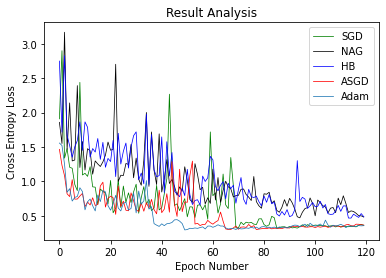

In [19]:
import matplotlib.pyplot as plt

#Create array of epochs for X axis
x_axis = np.zeros((120,1))
for i in range(120):
  x_axis[i] = i

#Plot Validation Loss for each algorithm
plt.title('Result Analysis')
plt.plot(x_axis, valid_loss_SGD, color='green', linewidth = 0.75,label='SGD')
plt.plot(x_axis, valid_loss_NAG[:], color='black', label='NAG', linewidth = 0.75,)
plt.plot(x_axis, valid_loss_HeavyBall[:], color='blue', label='HB', linewidth = 0.75,)
plt.plot(x_axis, valid_loss_ASGD[:], color='red', label='ASGD', linewidth = 0.75,)
plt.plot(x_axis, valid_loss_Adam[:], label='Adam', linewidth = 0.75,)

plt.legend()
 
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy Loss')
# plt.grid(axis='both')
plt.savefig('Resnet128_fixed_validloss.png')
plt.show()


In [ ]:
from google.colab import files
files.download("Resnet128_fixed_validloss.png")

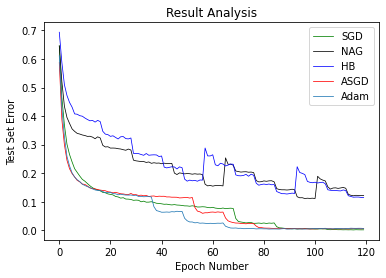

In [20]:
import matplotlib.pyplot as plt

#Create array of epochs for X axis
x_axis = np.zeros((120,1))
for i in range(120):
  x_axis[i] = i

#Plot Test Error for each algorithm
plt.title('Result Analysis')
plt.plot(x_axis, 1-train_accuracy_SGD[:], color='green', linewidth = 0.75,label='SGD')
plt.plot(x_axis, 1-train_accuracy_NAG[:], color='black', label='NAG', linewidth = 0.75,)
plt.plot(x_axis, 1-train_accuracy_HeavyBall[:], color='blue', label='HB', linewidth = 0.75,)
plt.plot(x_axis, 1-train_accuracy_ASGD[:], color='red', label='ASGD', linewidth = 0.75,)
plt.plot(x_axis, 1-train_accuracy_Adam[:], label='Adam', linewidth = 0.75,)

plt.legend()
 
plt.xlabel('Epoch Number')
plt.ylabel('Test Set Error')
# plt.grid(axis='both')
plt.savefig('Resnet128_fixed_test_error.png')
plt.show()


In [ ]:
files.download('Resnet128_fixed_test_error.png')